In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS
from statsforecast.arima import arima_string

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)
rcParams['figure.figsize'] = (18,7)

In [3]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso


ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


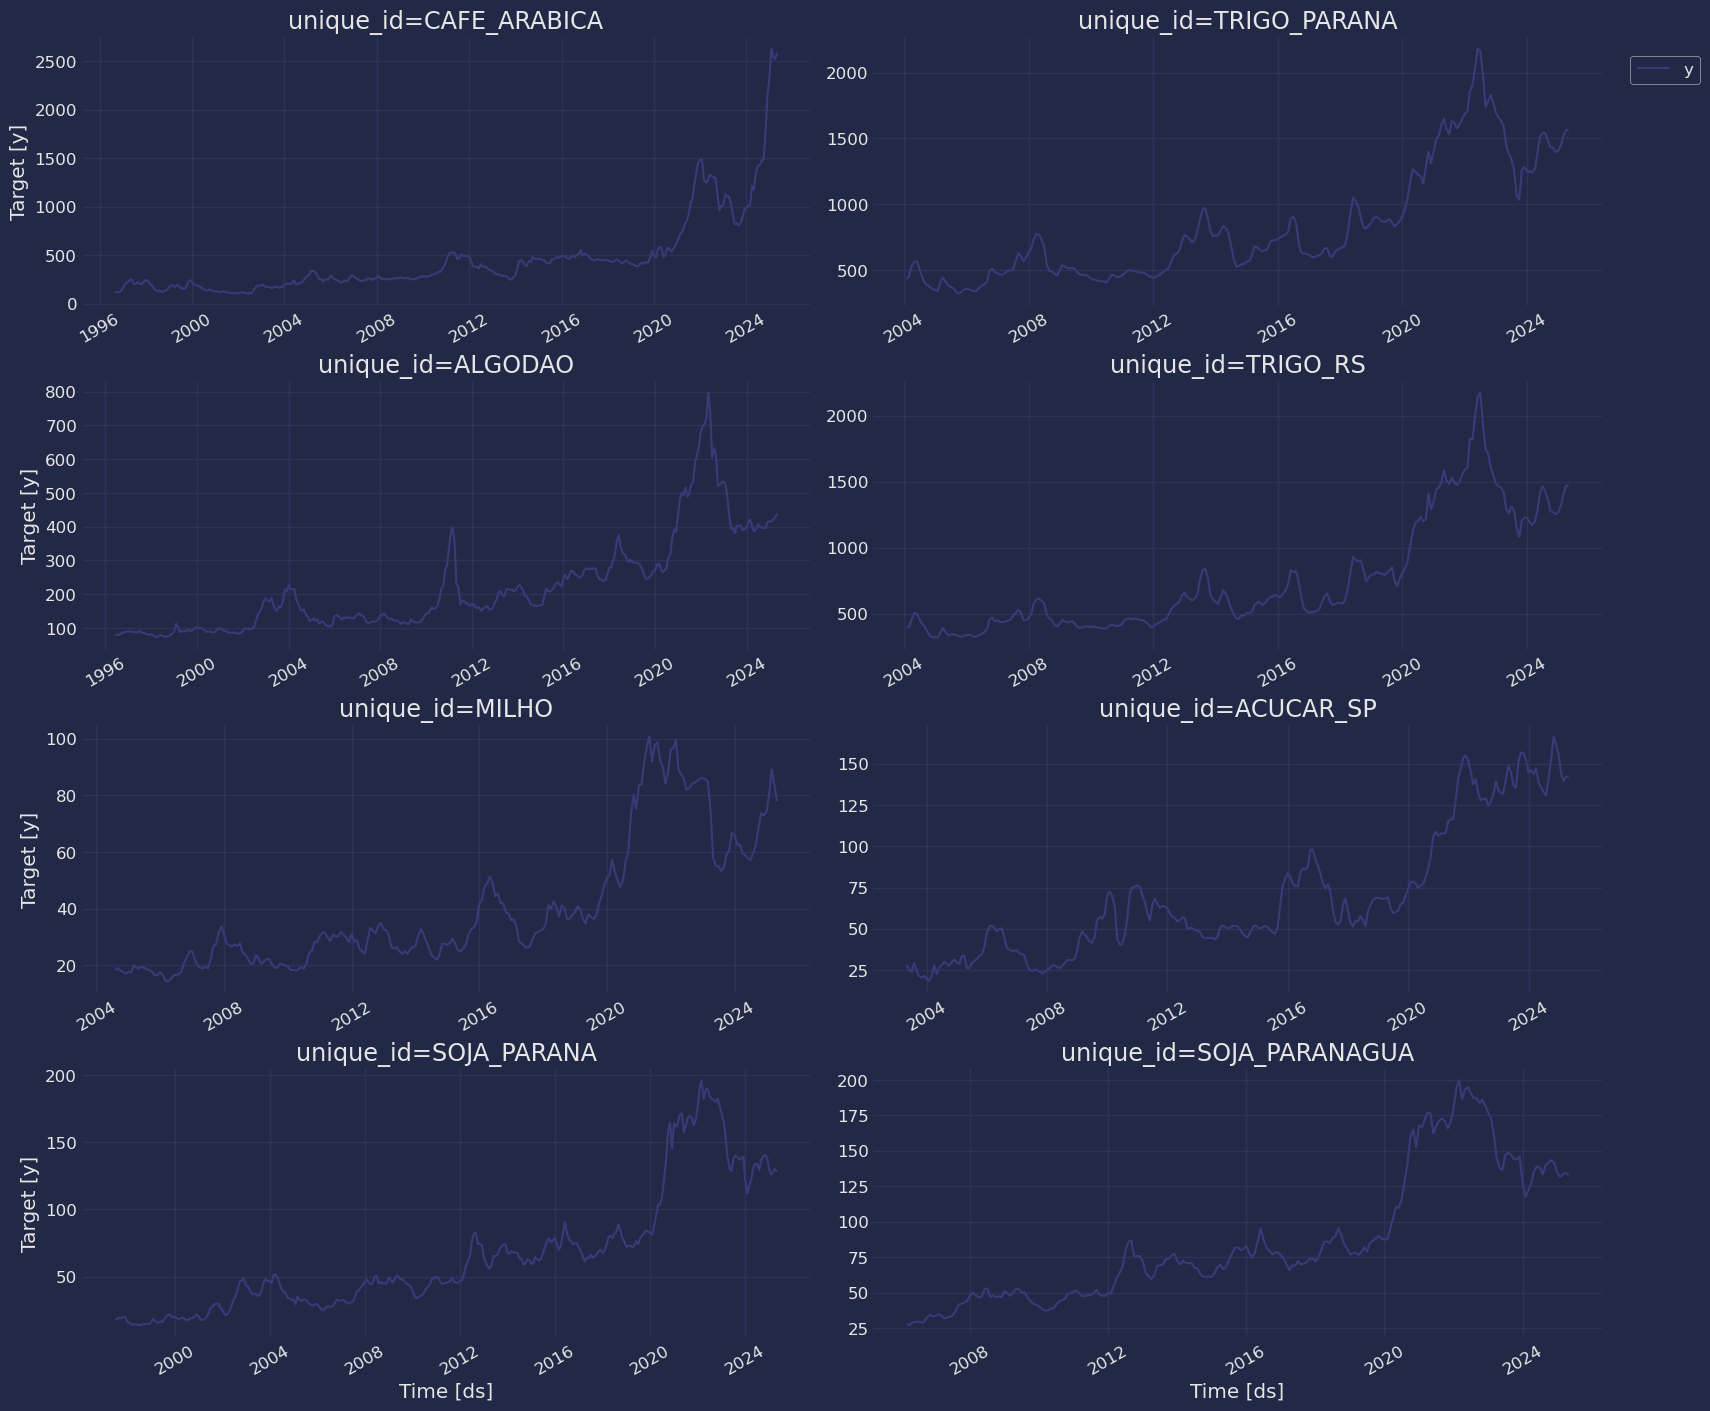

In [4]:
StatsForecast.plot(df_brl)

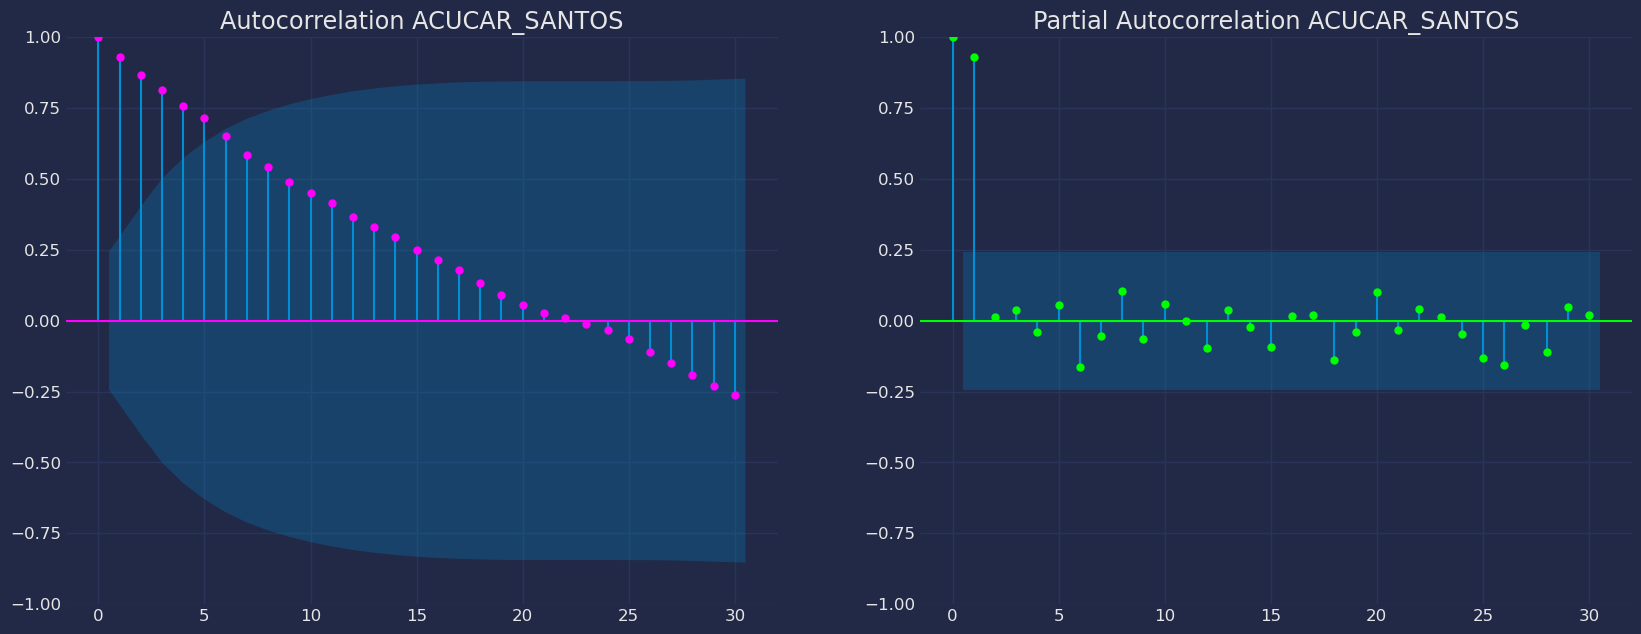

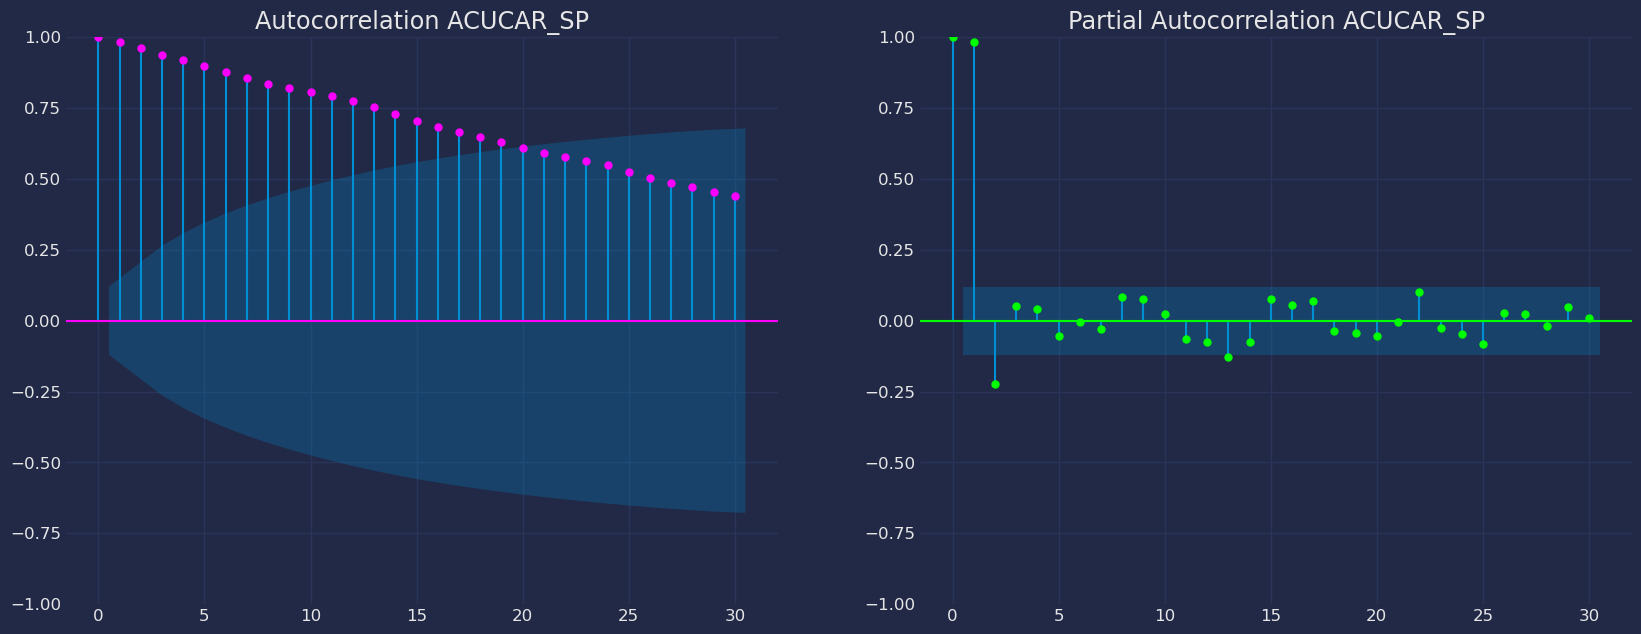

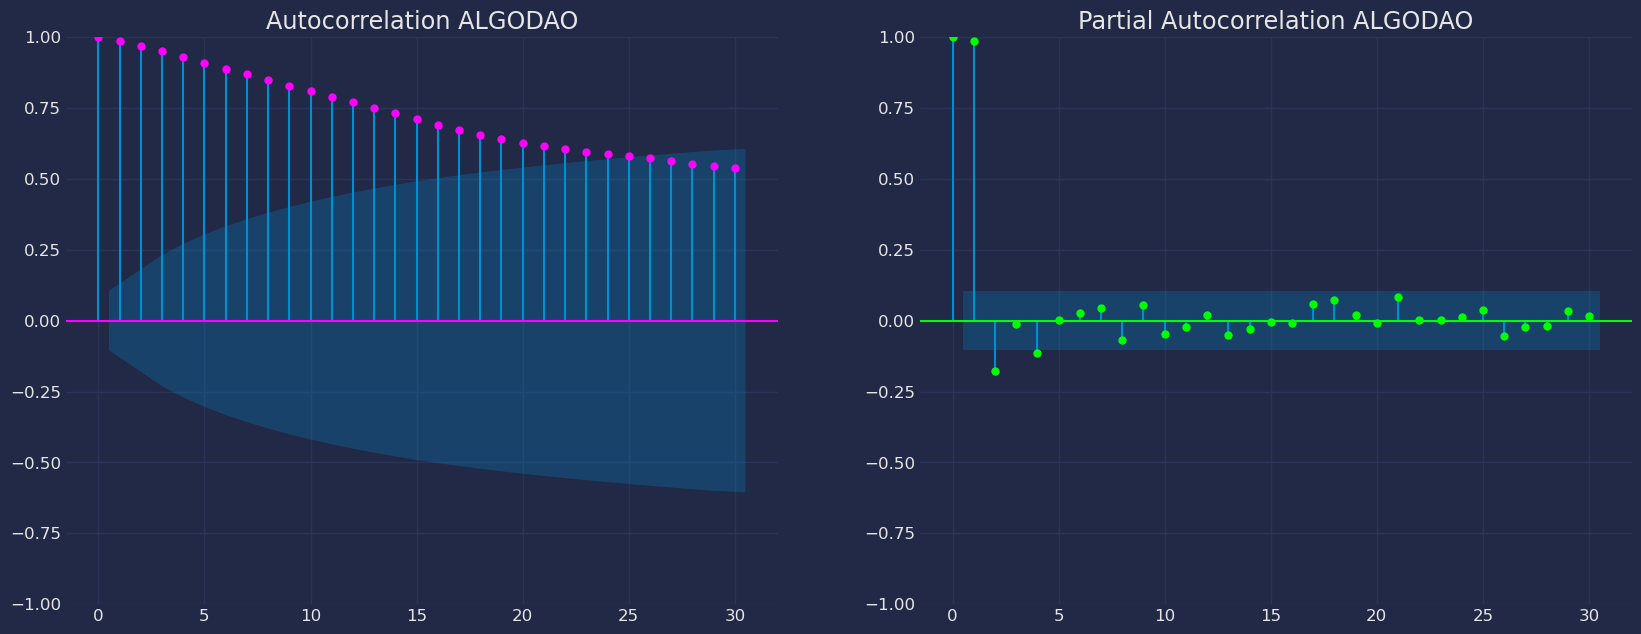

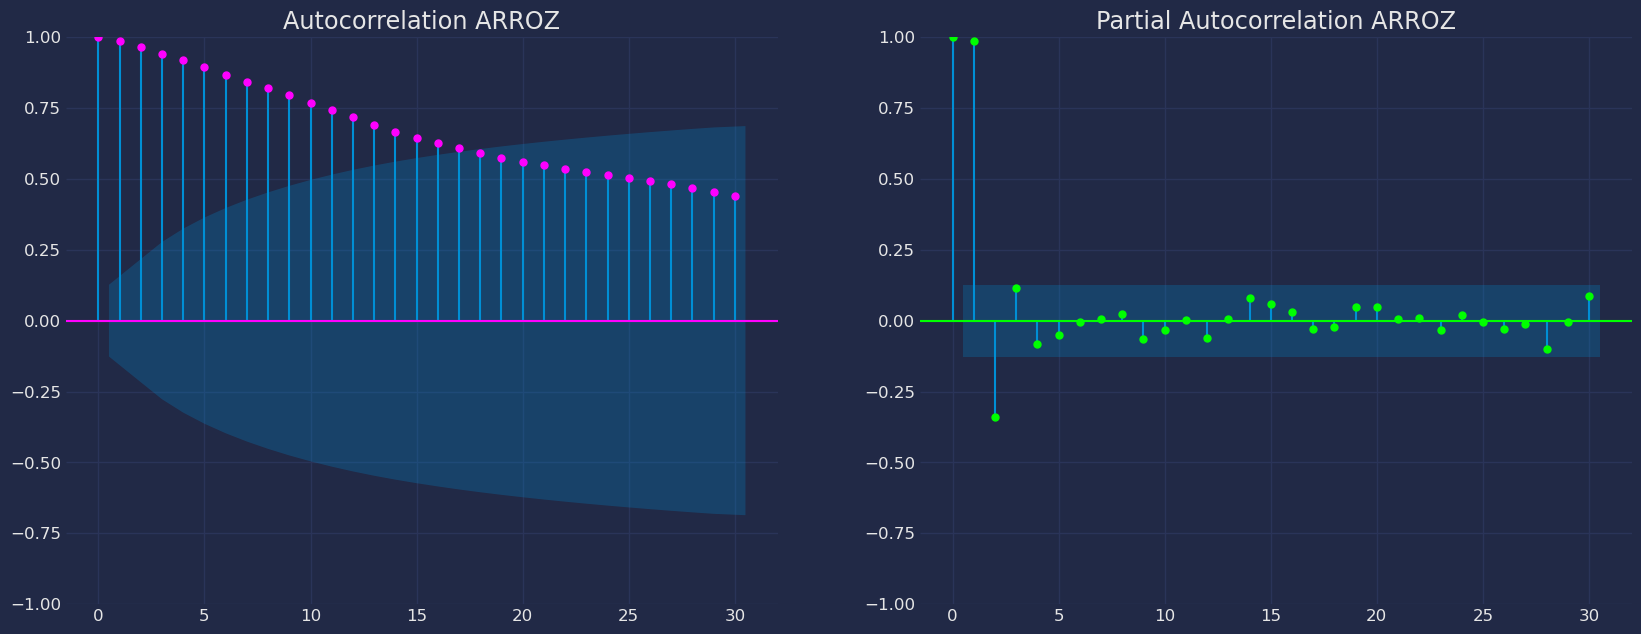

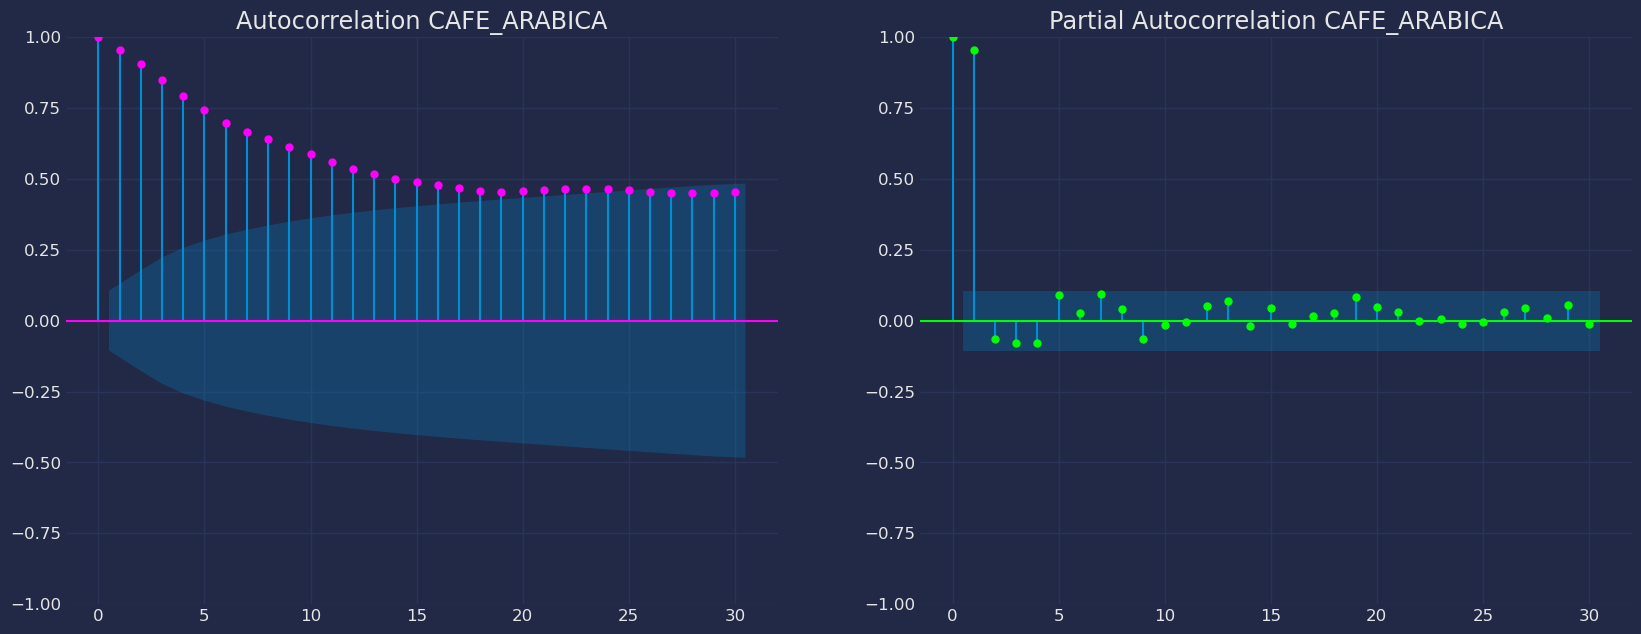

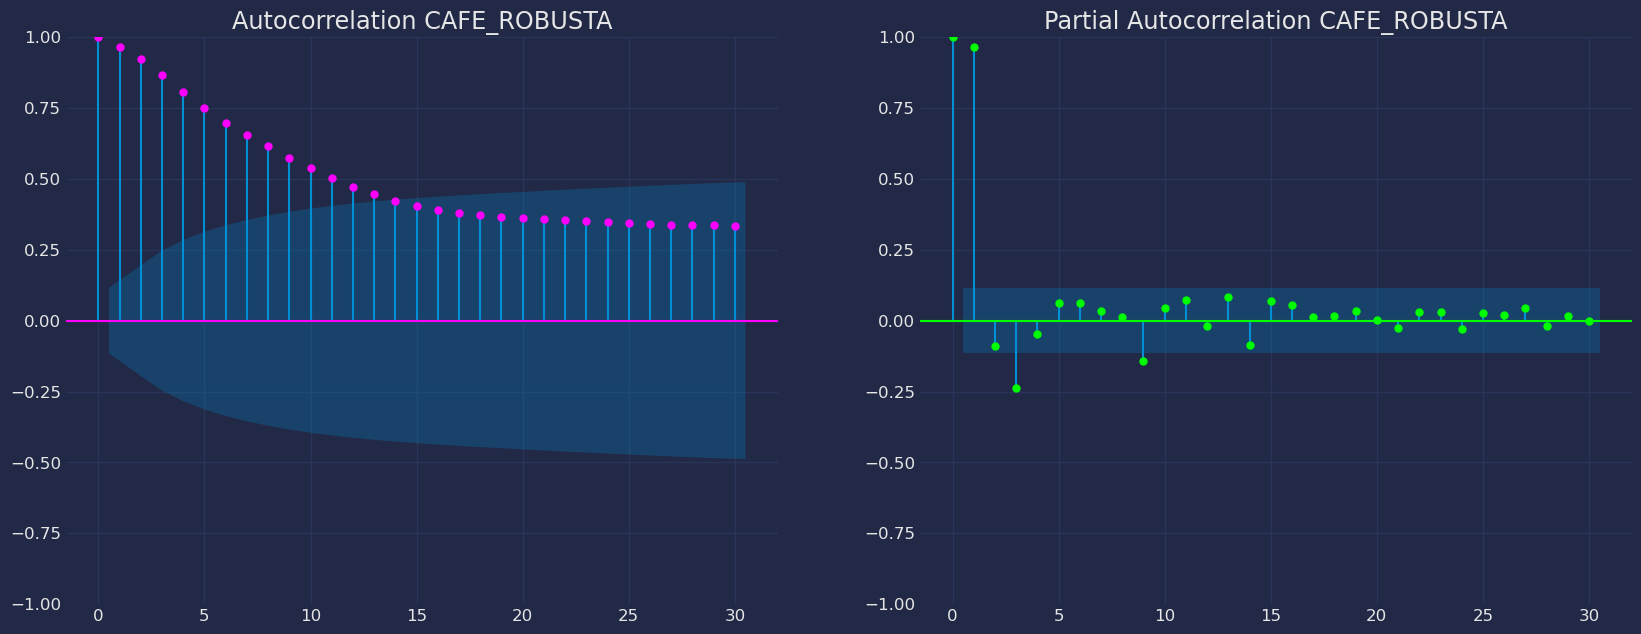

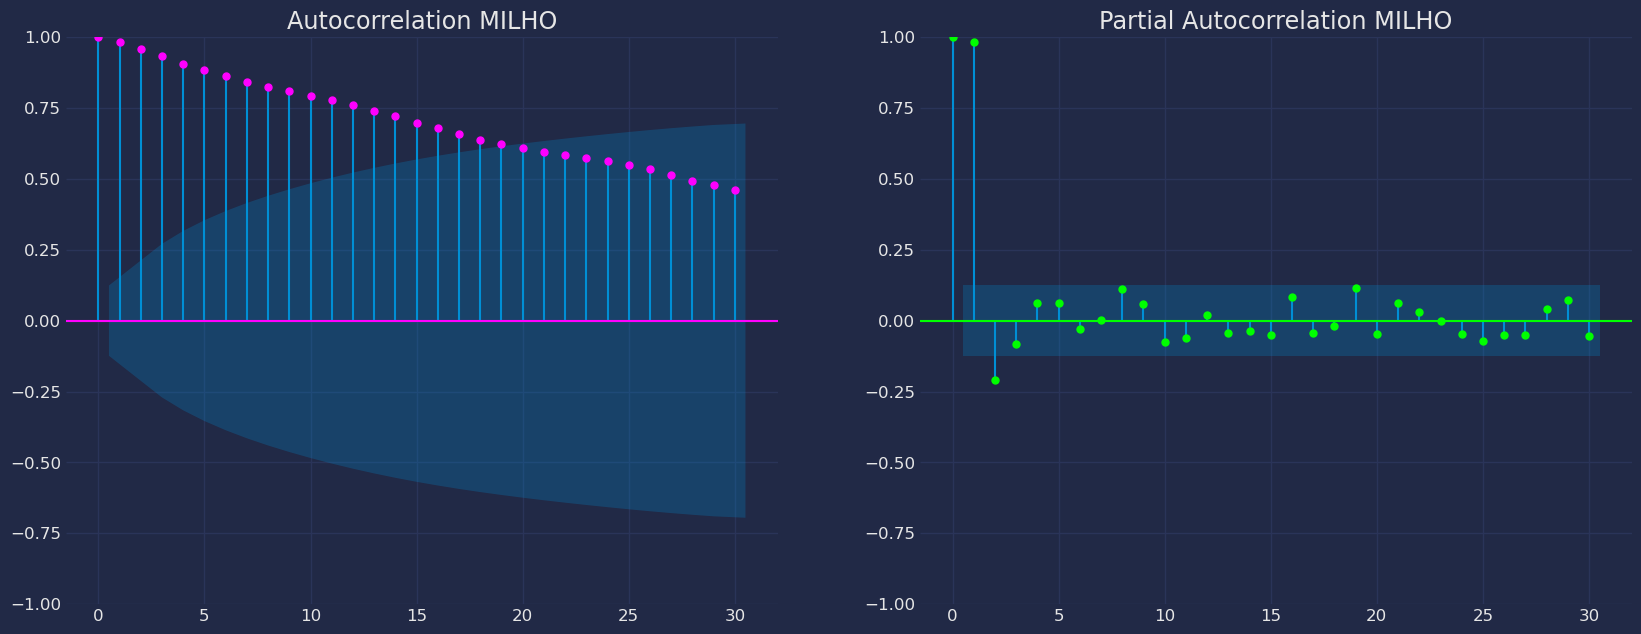

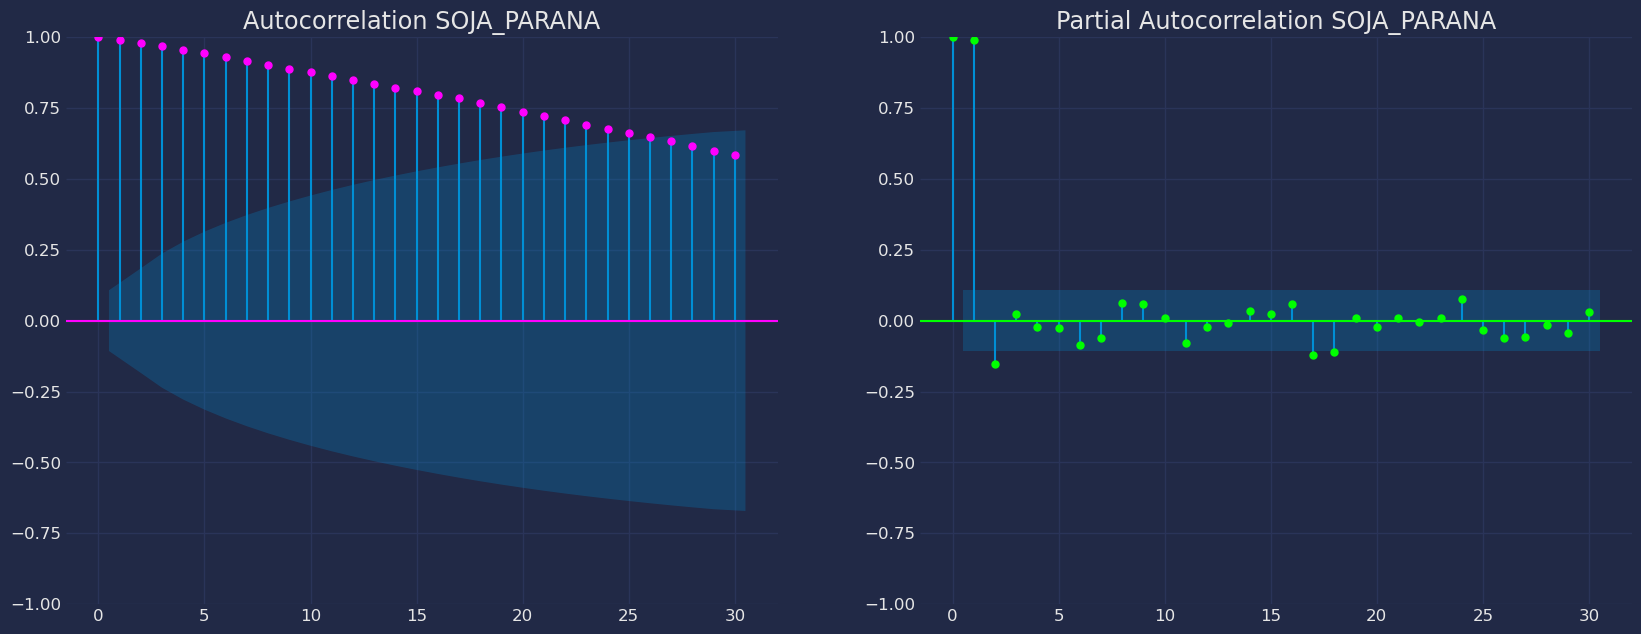

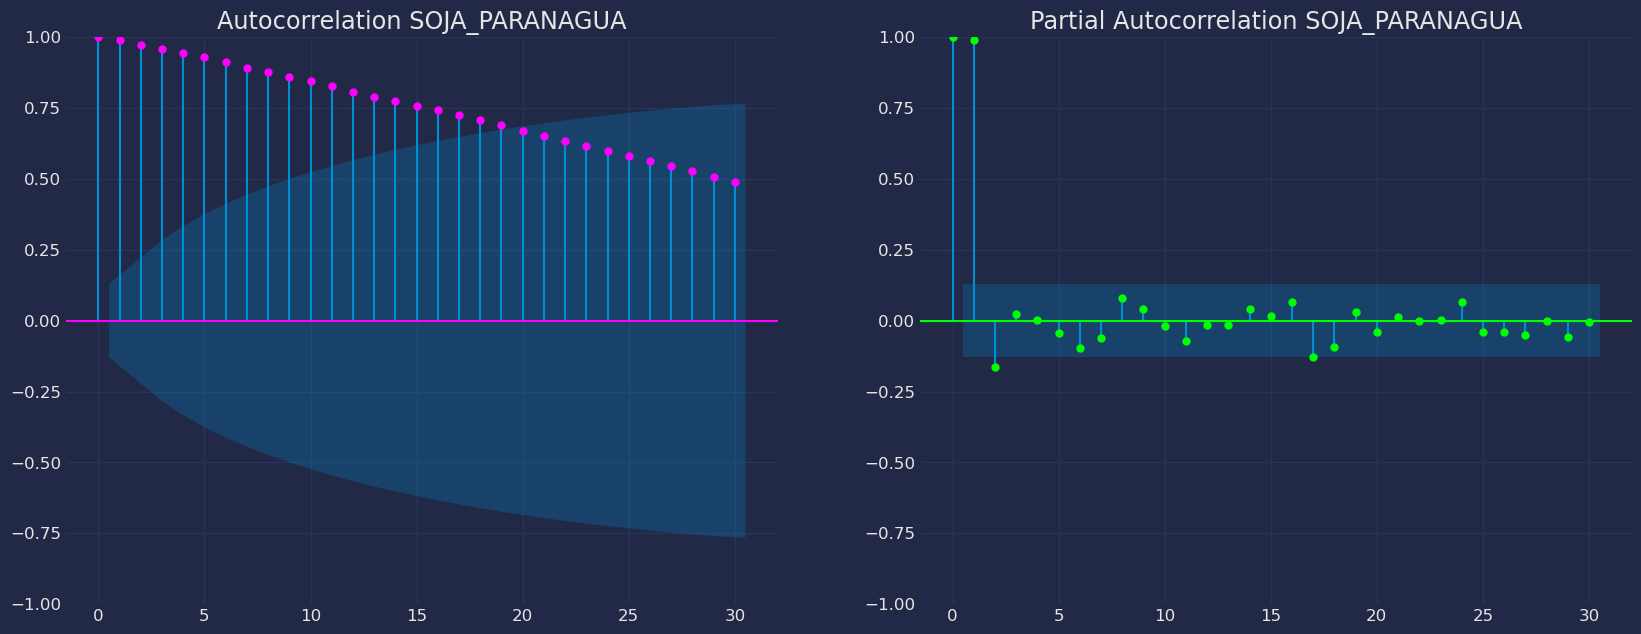

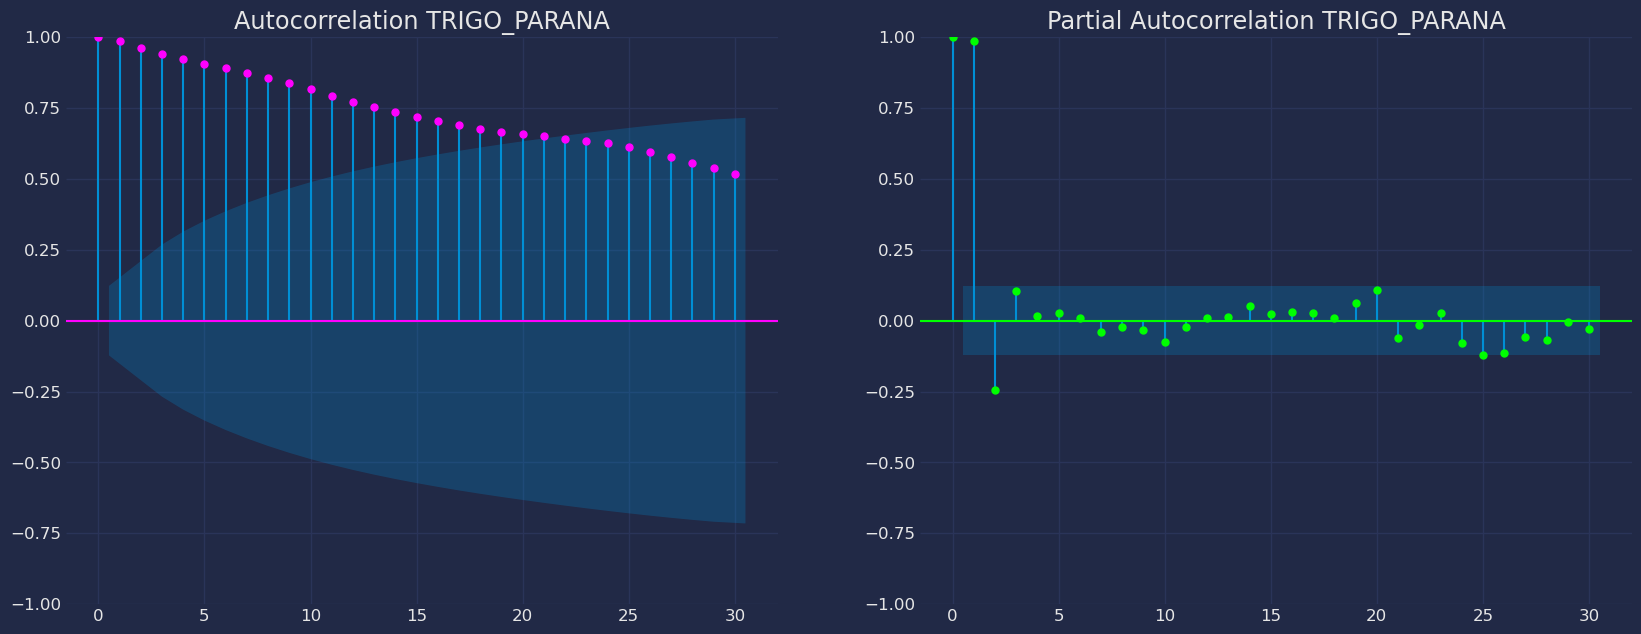

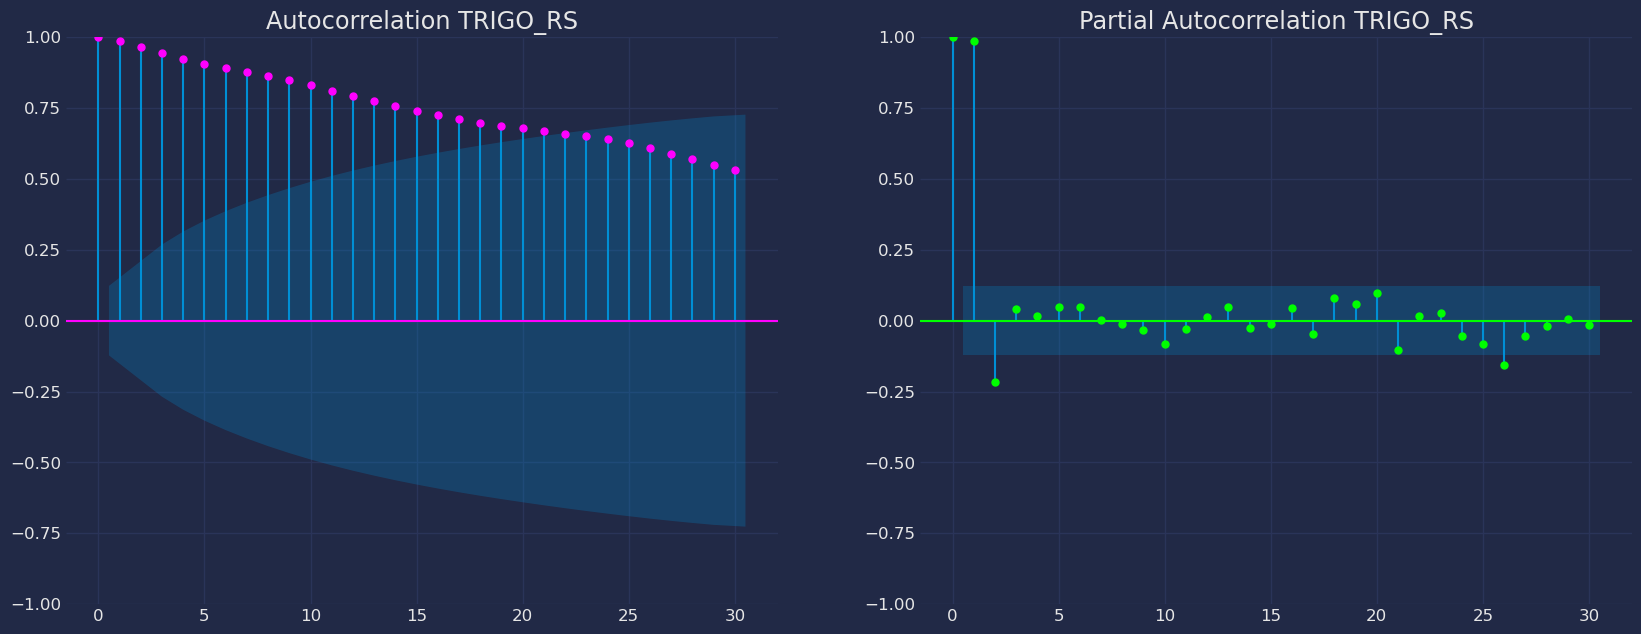

In [5]:
for u in df_brl['unique_id'].unique():
    fig, axs = plt.subplots(nrows=1, ncols=2)

    plot_acf(df_brl[df_brl['unique_id'] == u]["y"],  lags=30, ax=axs[0],color="fuchsia")
    axs[0].set_title(f'Autocorrelation {u}');

    plot_pacf(df_brl[df_brl['unique_id'] == u]["y"],  lags=30, ax=axs[1],color="lime")
    axs[1].set_title(f'Partial Autocorrelation {u}')

    plt.show();

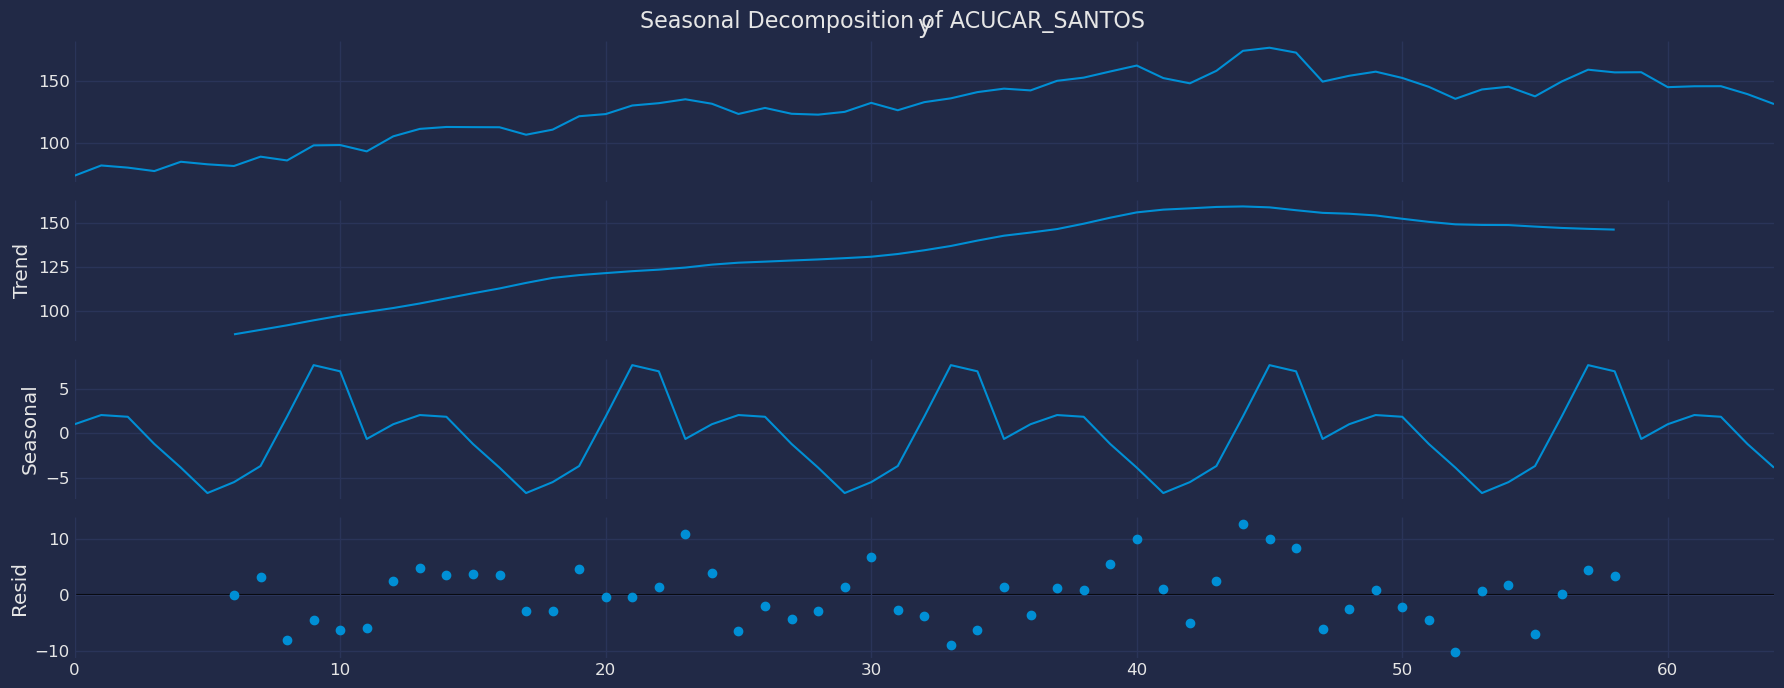

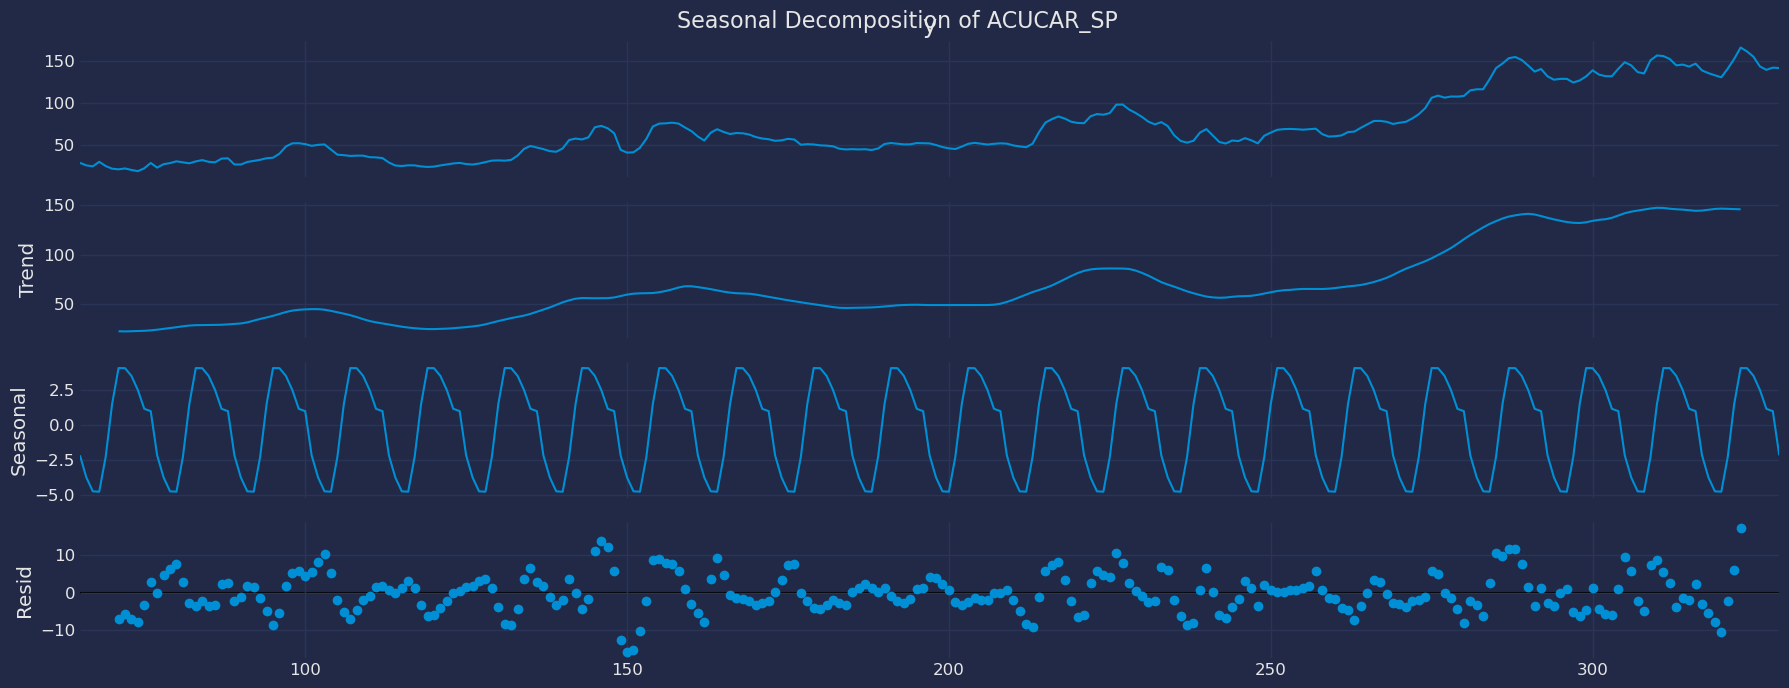

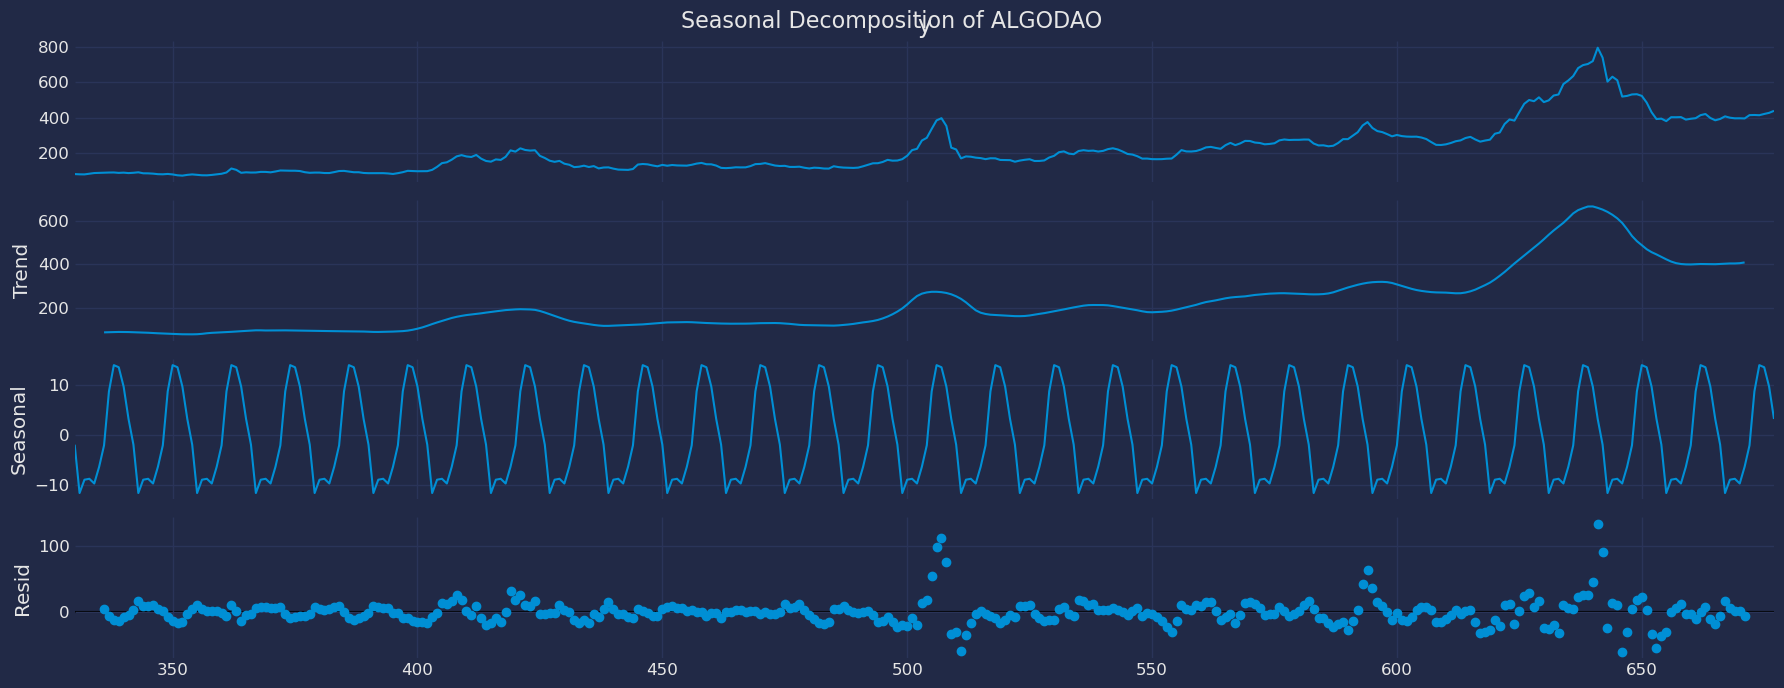

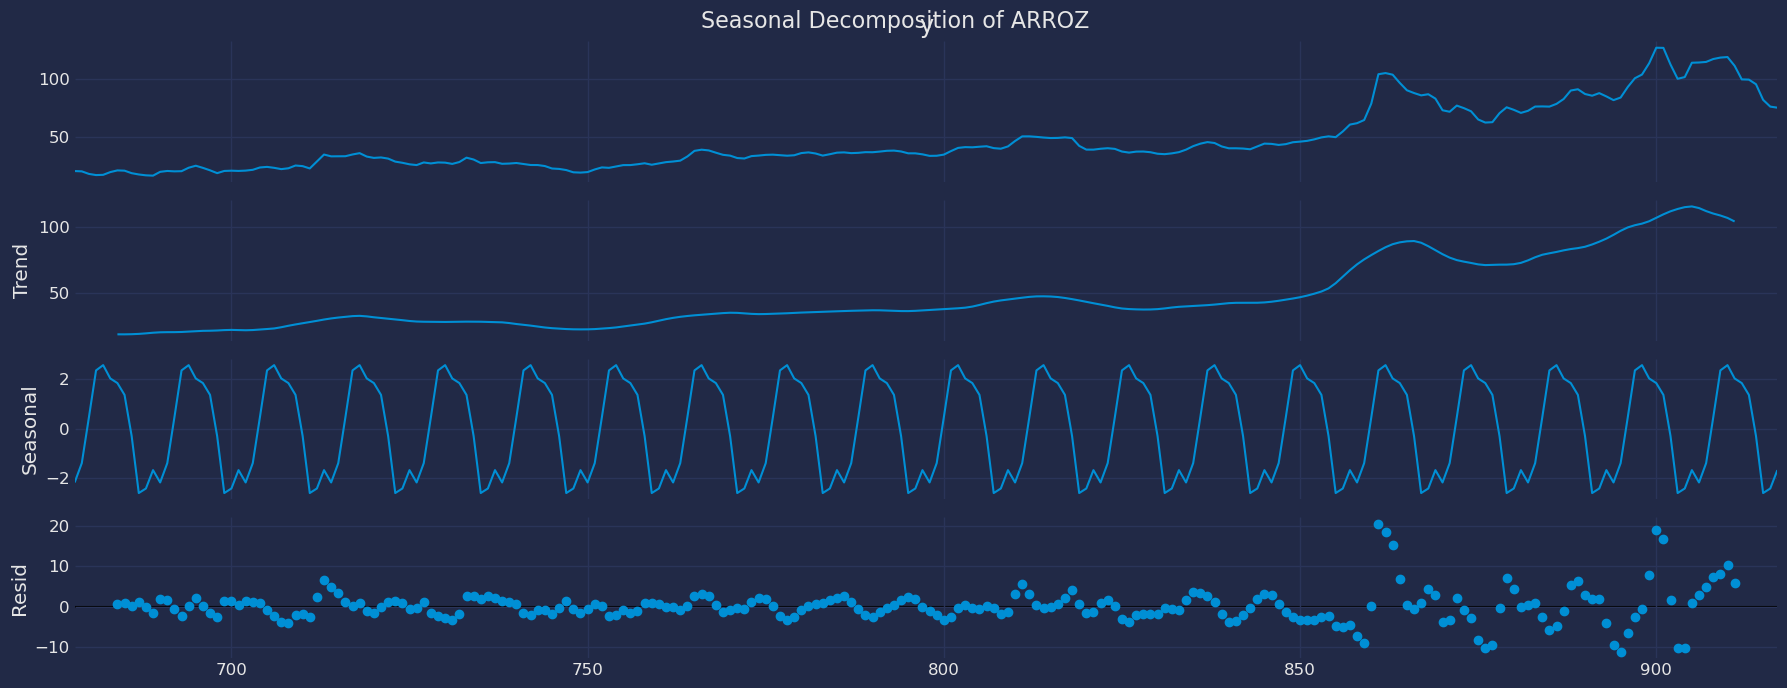

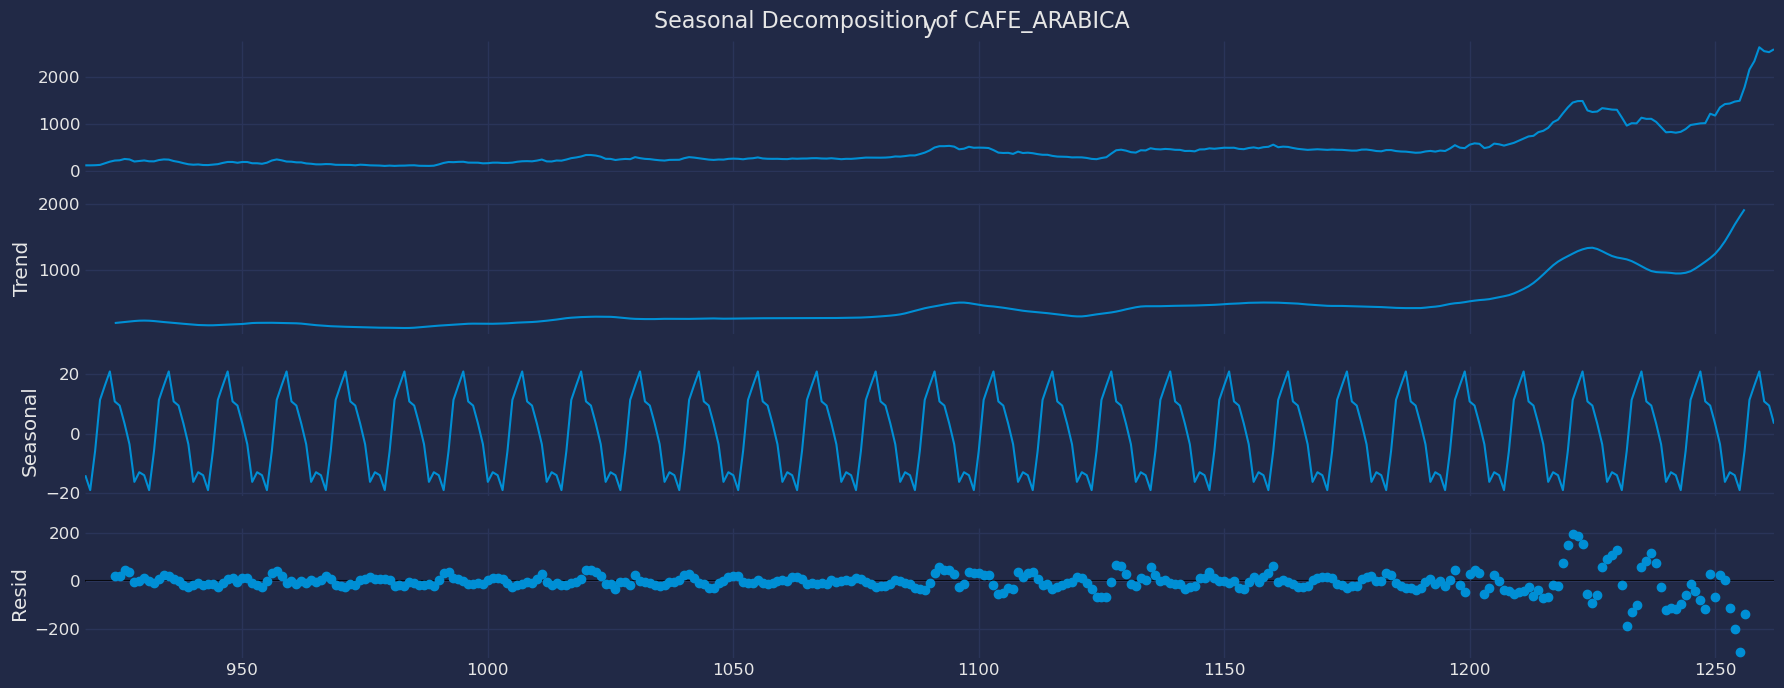

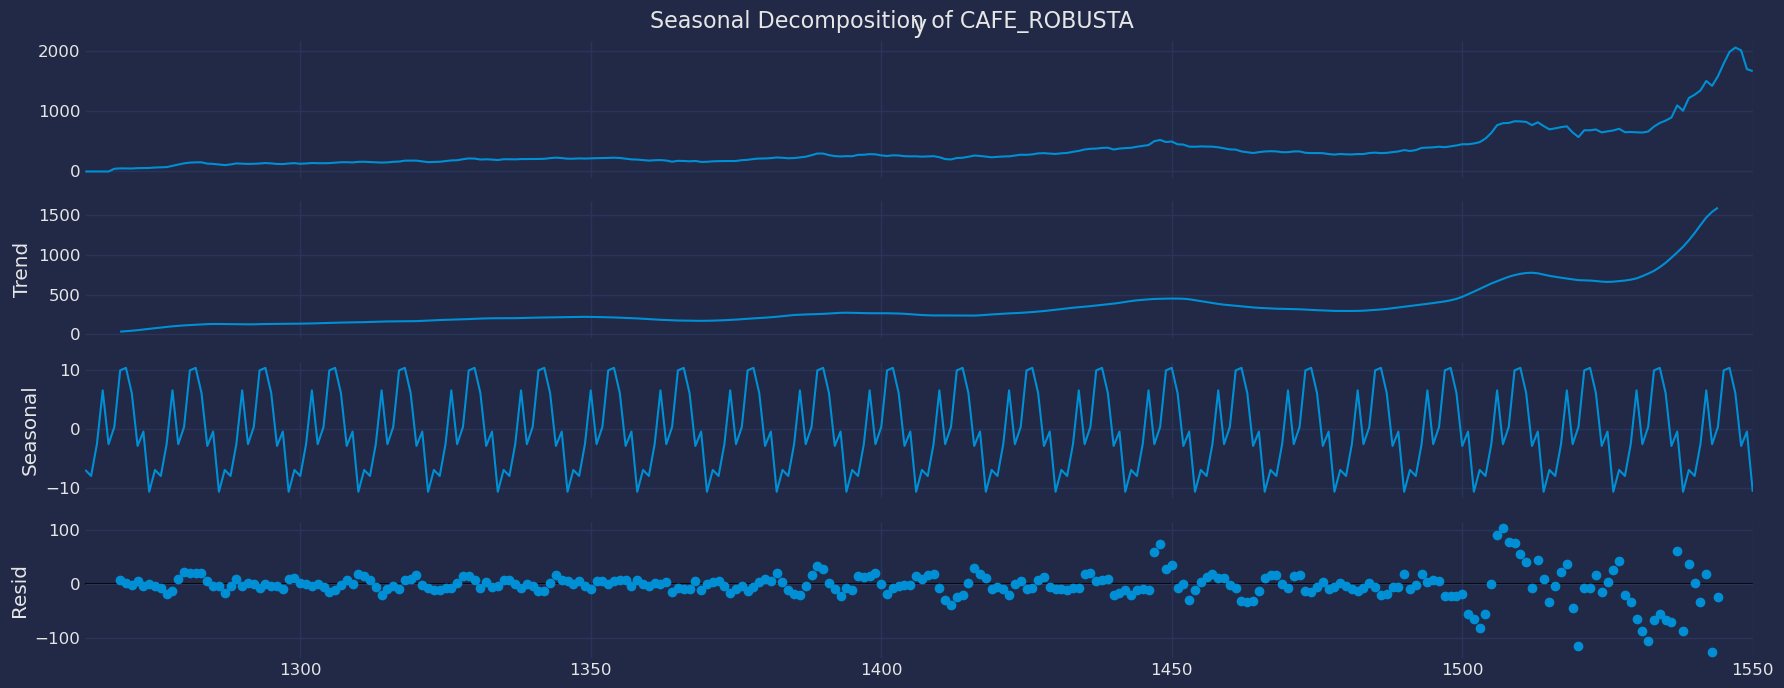

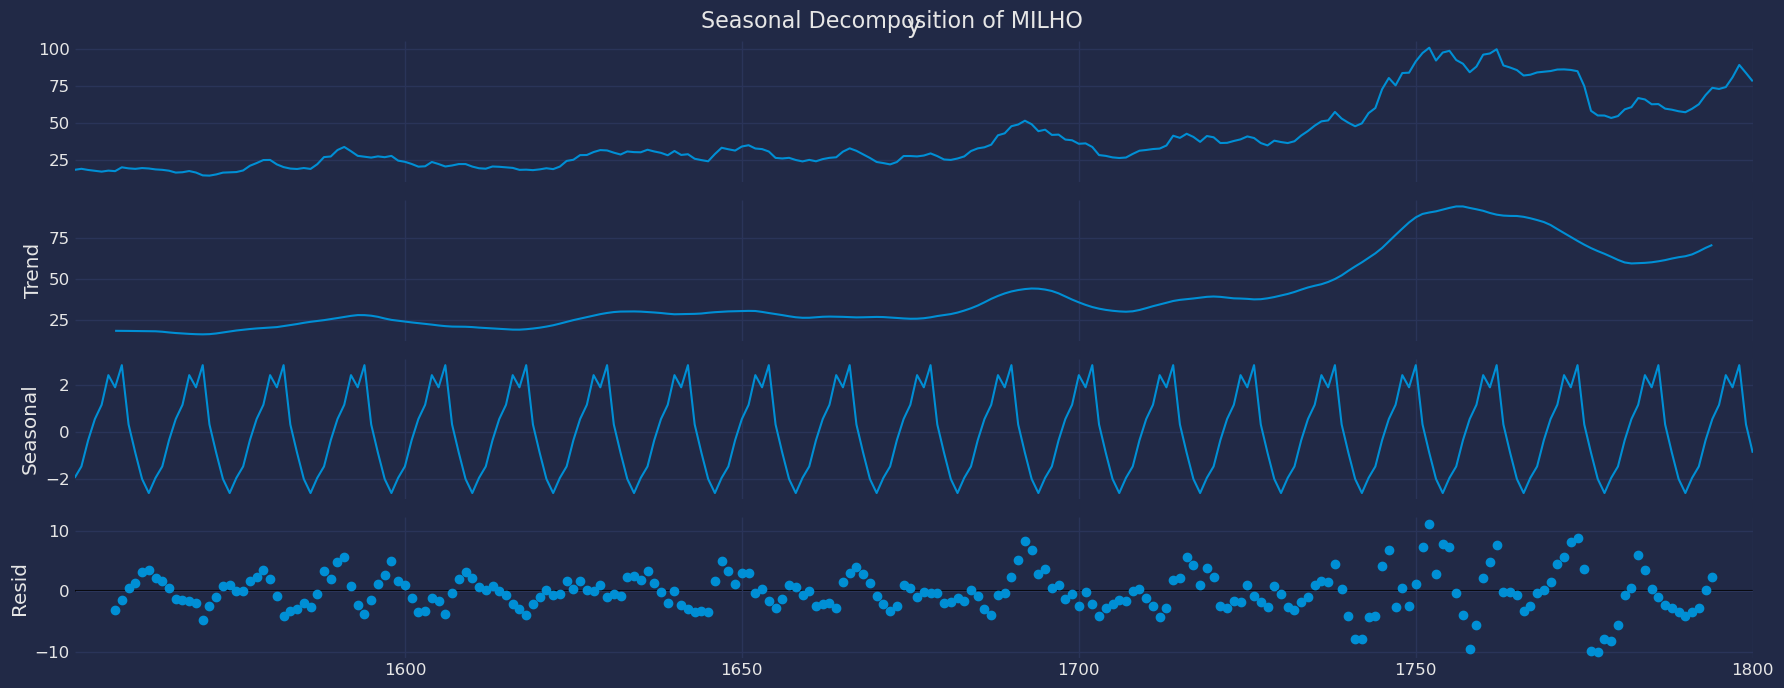

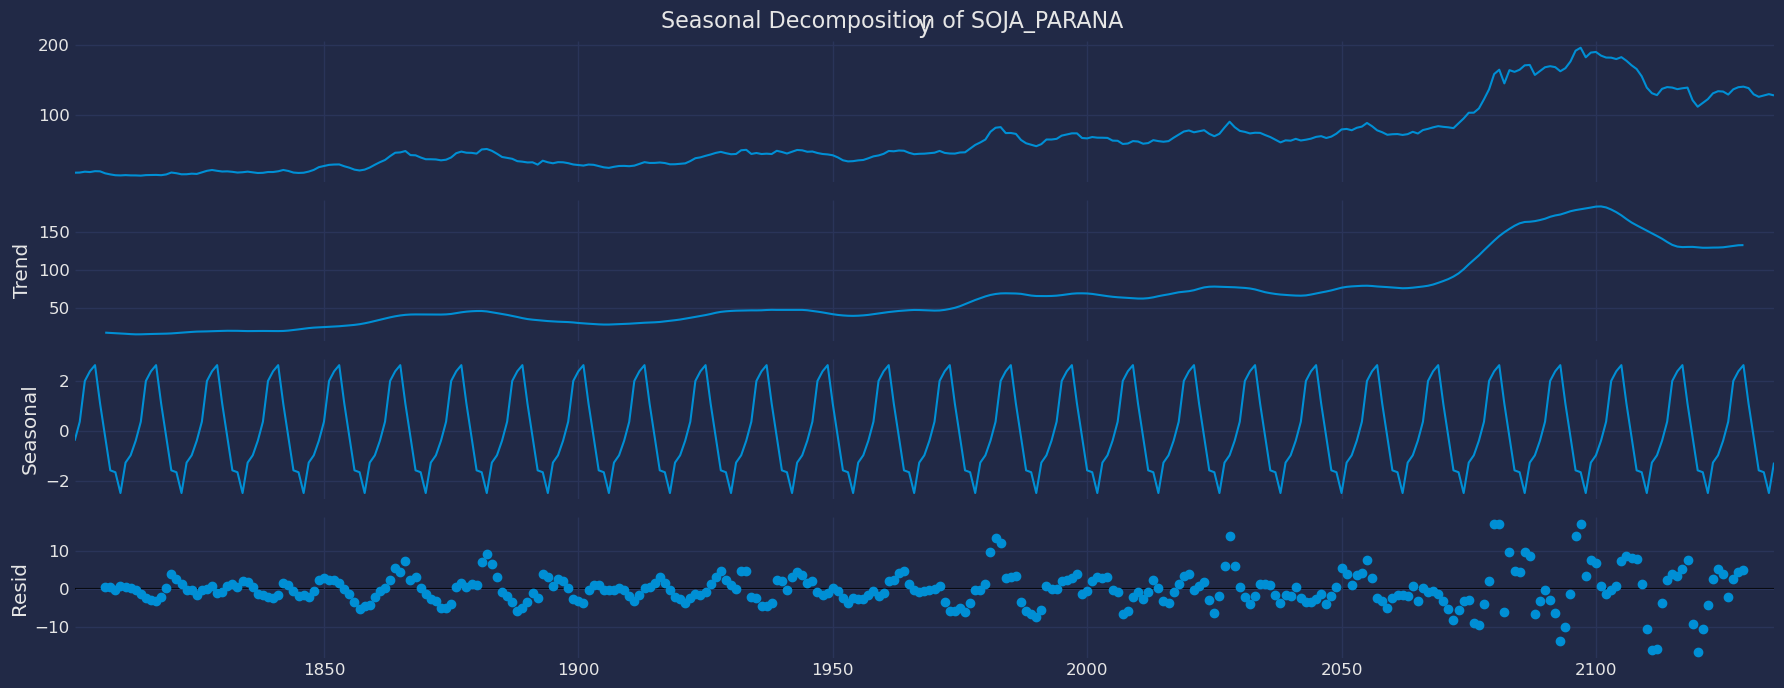

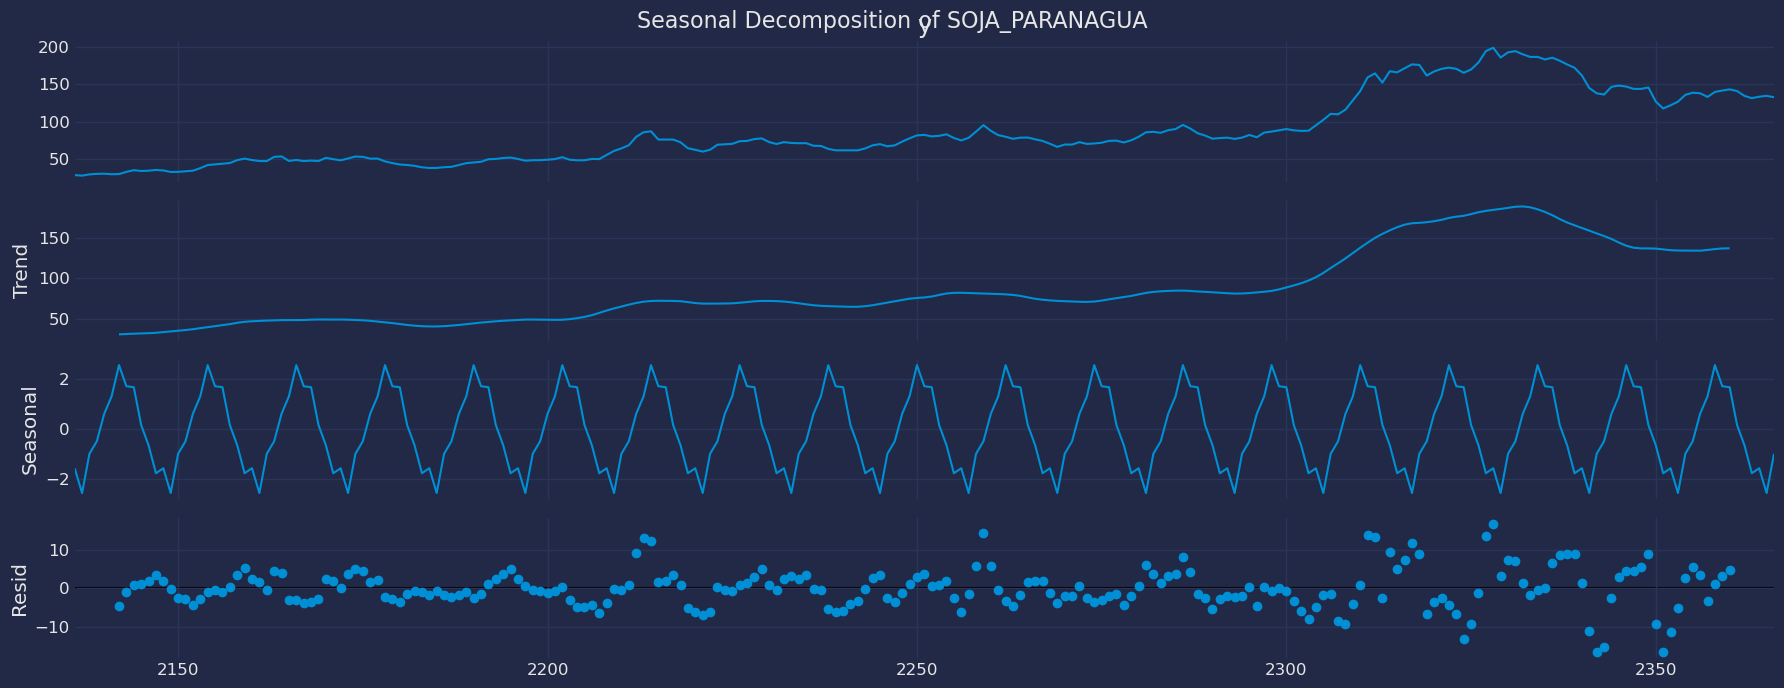

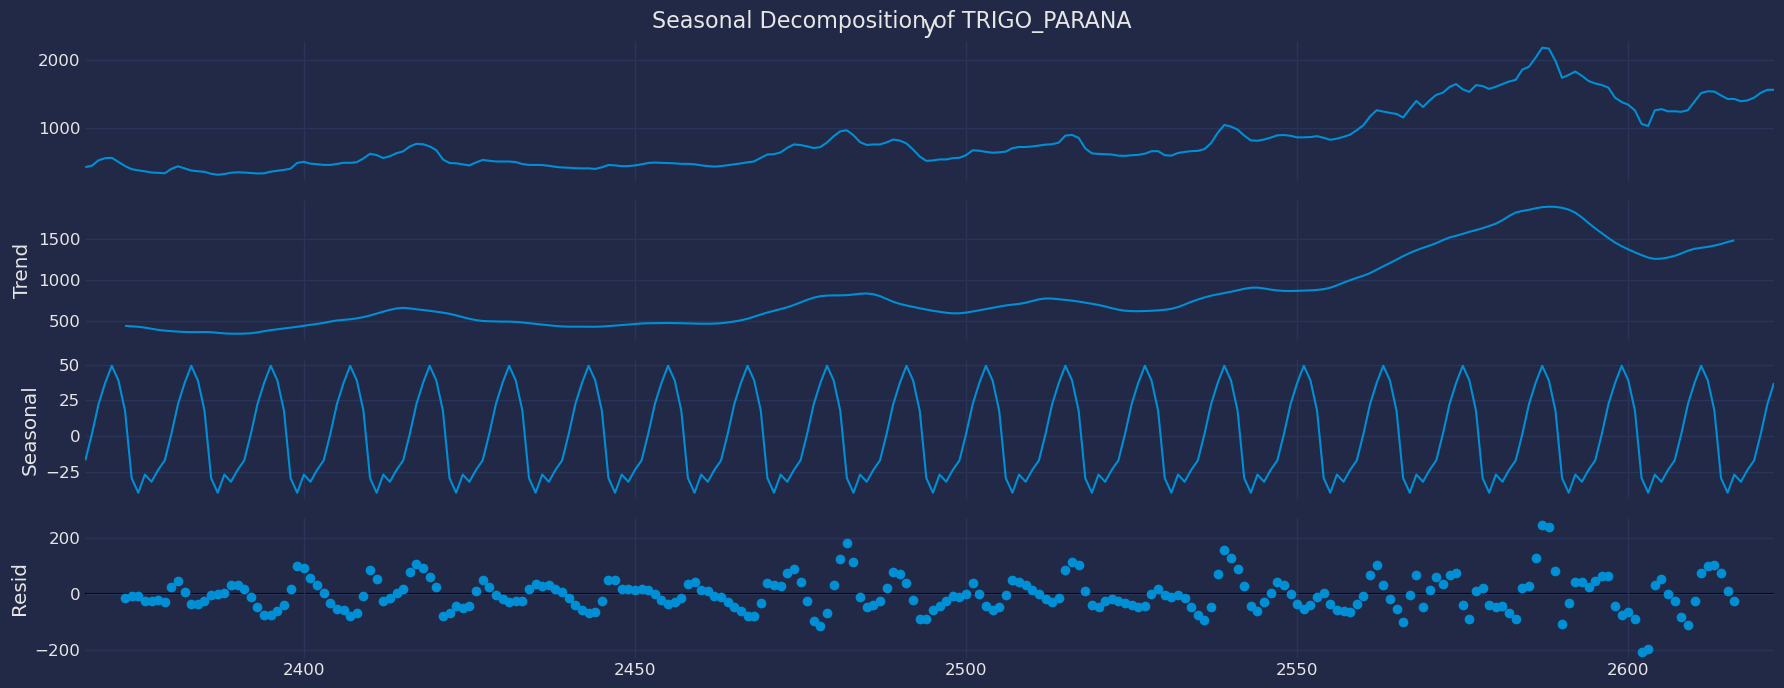

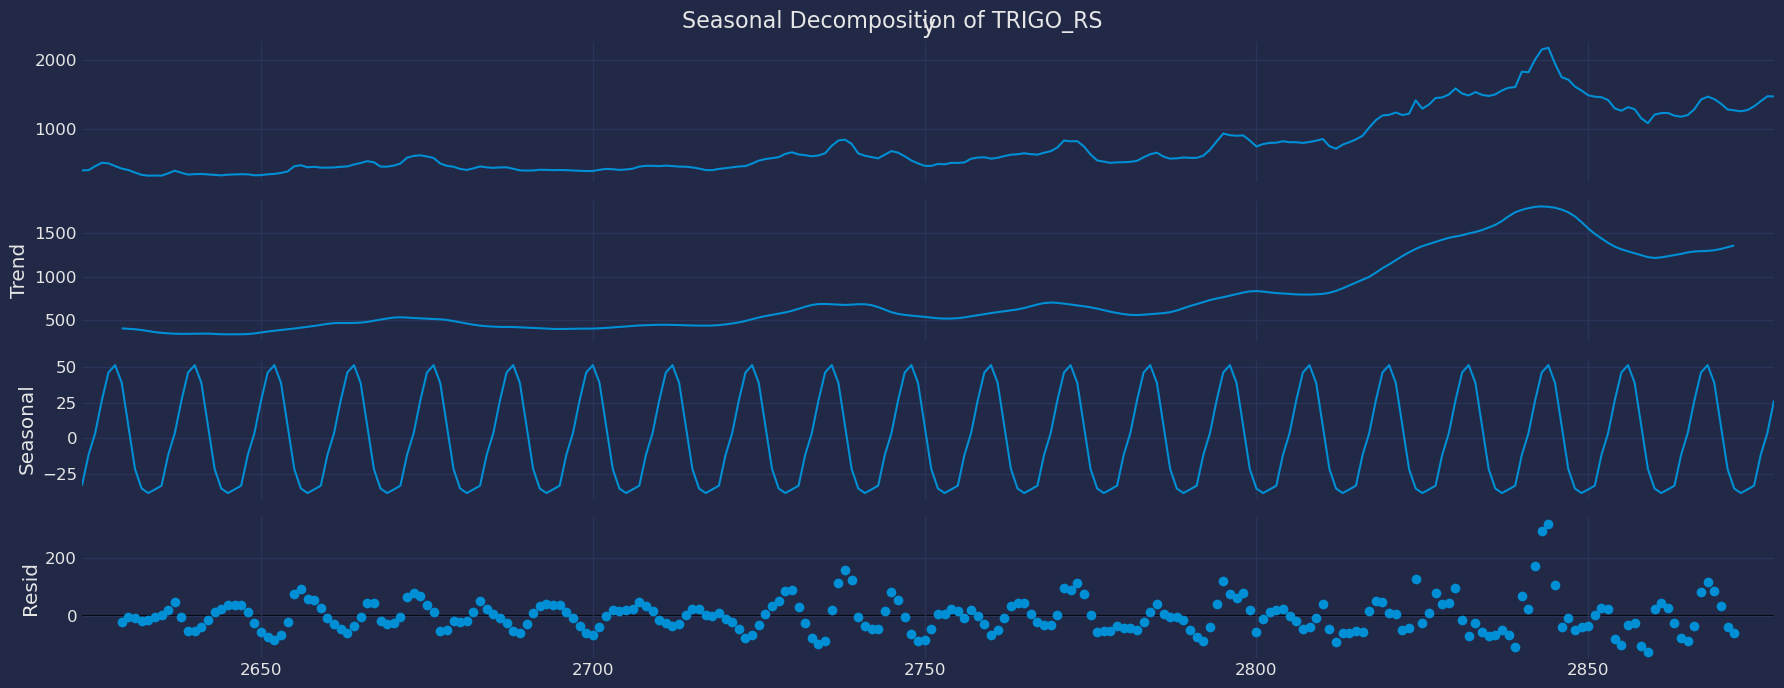

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose 

for u in df_brl['unique_id'].unique():
    a = seasonal_decompose(df_brl[df_brl['unique_id'] == u]["y"], model = "add", period=12)
    fig = a.plot()

    fig.suptitle(f"Seasonal Decomposition of {u}", fontsize=16)

    plt.show()

In [7]:
train, val, test = split_series(df_brl)
full_train = pd.concat([train, val])

Splitted data into TRAIN with size 1605, VALIDATION with size 406 and TEST with size 868


In [8]:
train.head()

ds          y      unique_id
0 2020-01-01  73.428636  ACUCAR_SANTOS
1 2020-02-01  81.636111  ACUCAR_SANTOS
2 2020-03-01  79.906364  ACUCAR_SANTOS
3 2020-04-01  77.113500  ACUCAR_SANTOS
4 2020-05-01  84.638500  ACUCAR_SANTOS

In [9]:
season_length = 12

models = [
    AutoARIMA(season_length=season_length),
    AutoETS(model='AZN')
]

In [10]:
sf = StatsForecast(models=models, freq='MS')

In [11]:
sf_models = sf.fit(full_train)

In [12]:
models_trained = sf_models.fitted_

In [13]:
forecasts = []
previous_values = full_train.copy()

for i in range(len(test)):
    sf_step = StatsForecast(models=models, freq="MS")

    # Reinjetando os modelos já treinados no lugar de fit
    sf_step.fitted_ = models_trained

    f_next = sf_step.predict(h=1)
    forecasts.append(f_next)

    obs = test.iloc[[i]][["unique_id", "ds", "y"]]
    previous_values = pd.concat([previous_values, obs])

forecasts_df = pd.concat(forecasts, ignore_index=True)

AttributeError: 'StatsForecast' object has no attribute '_exog'

In [ ]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    """
    Plota a série completa e as previsões para cada commodity individualmente
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lime', linewidth=1.5, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='cyan', linewidth=2, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='fuchsia', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['AutoARIMA'], 
                color='red', linewidth=2, linestyle='--', label='Previsão AutoARIMA')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)

In [27]:
import pmdarima as pm
from sktime.forecasting.exp_smoothing import ExponentialSmoothing as SKETS
from sktime.forecasting.base import ForecastingHorizon

In [28]:
df_brl = CommodityLoader.load_all_commodities(
    currency='BRL',
    preprocessing=True,
    monthly_aggregation='mean',
    limit_date=None
)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [37]:
df_brl.head()

ds          y      unique_id
0 2020-01-01  73.428636  ACUCAR_SANTOS
1 2020-02-01  81.636111  ACUCAR_SANTOS
2 2020-03-01  79.906364  ACUCAR_SANTOS
3 2020-04-01  77.113500  ACUCAR_SANTOS
4 2020-05-01  84.638500  ACUCAR_SANTOS

In [38]:
df_brl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2879 entries, 0 to 2878
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         2879 non-null   datetime64[ns]
 1   y          2879 non-null   float64       
 2   unique_id  2879 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 67.6+ KB


In [29]:
train, val, test = split_series(df_brl)
full_train = pd.concat([train, val])

Splitted data into TRAIN with size 1605, VALIDATION with size 406 and TEST with size 868


In [30]:
season_length = 12

models = [
    AutoARIMA(season_length=season_length),
    AutoETS(model="AZN")
]

sf = StatsForecast(models=models, freq='MS')
sf_models = sf.fit(full_train)

In [31]:
models_trained = sf_models.fitted_ 

In [32]:
models_trained

array([[AutoARIMA, AutoETS],
       [AutoARIMA, AutoETS],
       [AutoARIMA, AutoETS],
       [AutoARIMA, AutoETS],
       [AutoARIMA, AutoETS],
       [AutoARIMA, AutoETS],
       [AutoARIMA, AutoETS],
       [AutoARIMA, AutoETS],
       [AutoARIMA, AutoETS],
       [AutoARIMA, AutoETS],
       [AutoARIMA, AutoETS]], dtype=object)

In [33]:
models_trained[0][0].model_

{'coef': {'drift': 2.289644628099174},
 'sigma2': 34.32224803783469,
 'var_coef': array([[0.02272727]]),
 'mask': array([ True]),
 'loglik': -139.71491366568836,
 'aic': 283.4298273313767,
 'arma': (0, 0, 0, 0, 1, 1, 0),
 'residuals': array([  0.07113896,   5.91783012,  -4.0193921 ,  -5.08250826,
          5.23535537,  -4.34814463,  -3.65355767,   5.23903032,
         -5.34916844,   9.88987918,  -2.01940653,  -7.40414463,
          9.85880274,   3.70696356,  -0.7373741 ,  -2.42747072,
         -2.38012082,  -8.32059701,   1.80368871,   8.5393597 ,
         -0.55198229,   4.63328394,  -0.41264463,   0.86328394,
         -5.90202558, -10.52185014,   2.57305872,  -7.01024271,
         -2.99813745,  -0.03438489,   4.97654585,  -8.25546243,
          4.2452208 ,   0.79390299,   2.72685537,   0.50364109,
         -3.70211216,   5.44520386,   0.27238436,   2.68165972,
          2.50308264, -12.39903857,  -6.52773987,   7.81120423,
         13.83726842]),
 'code': 2,
 'n_cond': 0,
 'nobs': 44,

In [ ]:
full_train["ds"] = pd.to_datetime(full_train["ds"]).dt.to_period("M")
test["ds"] = pd.to_datetime(test["ds"]).dt.to_period("M")

In [41]:
# ---------------------------
# Helpers
# ---------------------------
def get_arima_orders(sf_arima):
    info = getattr(sf_arima, "model_", None)
    if not isinstance(info, dict) or "arma" not in info:
        raise ValueError("Não foi possível encontrar 'arma' em sf_arima.model_")
    p, d, q, P, D, Q, m = info["arma"]
    order = (int(p), int(d), int(q))
    seasonal_order = None if m <= 1 or (P, D, Q) == (0, 0, 0) else (int(P), int(D), int(Q), int(m))
    return order, seasonal_order

def get_ets_spec(sf_ets, default_sp):
    info = getattr(sf_ets, "model_", None)
    code = info.get("model", "ANN")
    trend_code = code[1] if len(code) > 1 else "N"
    seas_code  = code[2] if len(code) > 2 else "N"
    trend = {"A": "add", "M": "mul", "N": None}.get(trend_code, None)
    seasonal = {"A": "add", "M": "mul", "N": None}.get(seas_code, None)
    phi = info.get("phi", None)
    damped = (phi is not None) and (phi != 1)
    sp = int(info.get("m", info.get("season_length", default_sp)))
    return {"trend": trend, "seasonal": seasonal, "damped_trend": damped, "sp": sp}

In [44]:
# ---------------------------
# Rollout multi-série
# ---------------------------
def one_step_multiseries(full_train, test, models_trained, season_length=12):
    first_row = models_trained[0]
    col_map = {type(first_row[j]).__name__: j for j in range(len(first_row))}
    j_arima = col_map["AutoARIMA"]
    j_ets   = col_map["AutoETS"]

    uids = full_train["unique_id"].unique().tolist()
    all_preds = []

    for i, uid in enumerate(uids):
        y_tr = full_train[full_train["unique_id"] == uid].set_index("ds")["y"].astype(float)
        y_te = test[test["unique_id"] == uid].set_index("ds")["y"].astype(float)
        if y_te.empty: 
            continue

        sf_arima = models_trained[i, j_arima]
        sf_ets   = models_trained[i, j_ets]

        # ARIMA (pmdarima)
        order, seasonal_order = get_arima_orders(sf_arima)
        if seasonal_order is None:
            arima = pm.ARIMA(order=order, suppress_warnings=True)
        else:
            arima = pm.ARIMA(order=order, seasonal_order=seasonal_order, suppress_warnings=True)
        arima.fit(y_tr.to_timestamp())  # pmdarima usa DatetimeIndex

        # ETS (sktime)
        ets_spec = get_ets_spec(sf_ets, default_sp=season_length)
        ets = SKETS(
            trend=ets_spec["trend"],
            damped_trend=ets_spec["damped_trend"],
            seasonal=ets_spec["seasonal"],
            sp=ets_spec["sp"],
            initialization_method="estimated",
        )
        ets.fit(y_tr)  # já está em PeriodIndex

        preds = []
        for ts, y_true in y_te.items():
            # ARIMA
            yhat_arima = arima.predict(1)[0]
            arima.update(y_true)

            # ETS
            fh = ForecastingHorizon(pd.PeriodIndex([ts], freq="M"), is_relative=False)
            yhat_ets = ets.predict(fh).iloc[0]
            ets.update(
                pd.Series([y_true], index=pd.PeriodIndex([ts], freq="M")),
                update_params=False
            )

            preds.append({
                "unique_id": uid,
                "ds": ts,
                "yhat_arima": float(yhat_arima),
                "yhat_ets": float(yhat_ets),
            })

        all_preds.append(pd.DataFrame(preds))

    return pd.concat(all_preds, ignore_index=True)


In [45]:
final_preds = one_step_multiseries(full_train, test, sf_models.fitted_, season_length=12)

/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_1247/587420155.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat_arima = arima.predict(1)[0]
/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hiraeth/anaconda3/envs/smps/lib/pyth

In [47]:
final_preds.head()

unique_id       ds  yhat_arima  yhat_ets
0  ACUCAR_SANTOS  2023-10  119.971101   174.173
1  ACUCAR_SANTOS  2023-11  121.204016   174.173
2  ACUCAR_SANTOS  2023-12  122.302056   174.173
3  ACUCAR_SANTOS  2024-01  122.861794   174.173
4  ACUCAR_SANTOS  2024-02  123.499321   174.173

In [48]:
final_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   unique_id   868 non-null    object   
 1   ds          868 non-null    period[M]
 2   yhat_arima  868 non-null    float64  
 3   yhat_ets    868 non-null    float64  
dtypes: float64(2), object(1), period[M](1)
memory usage: 27.2+ KB


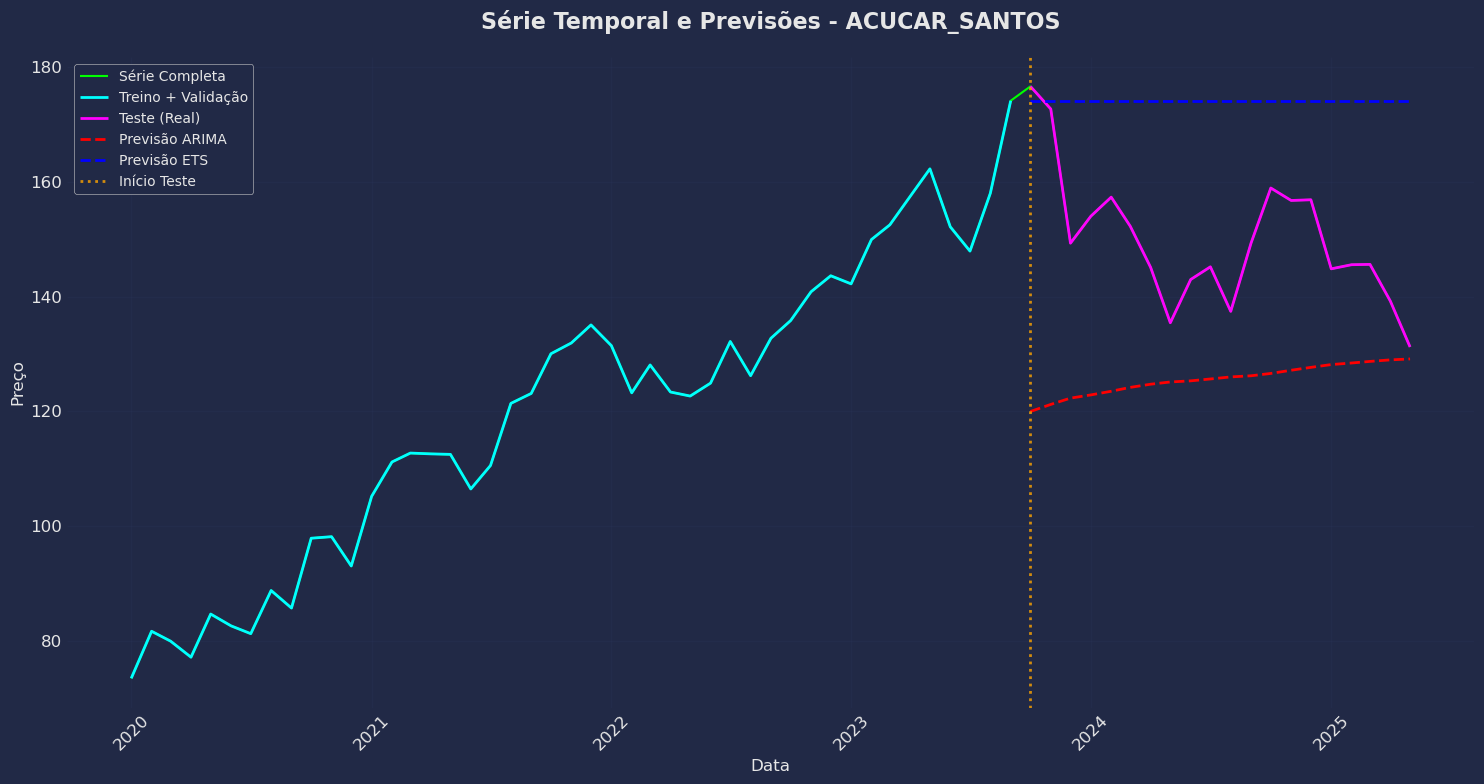

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


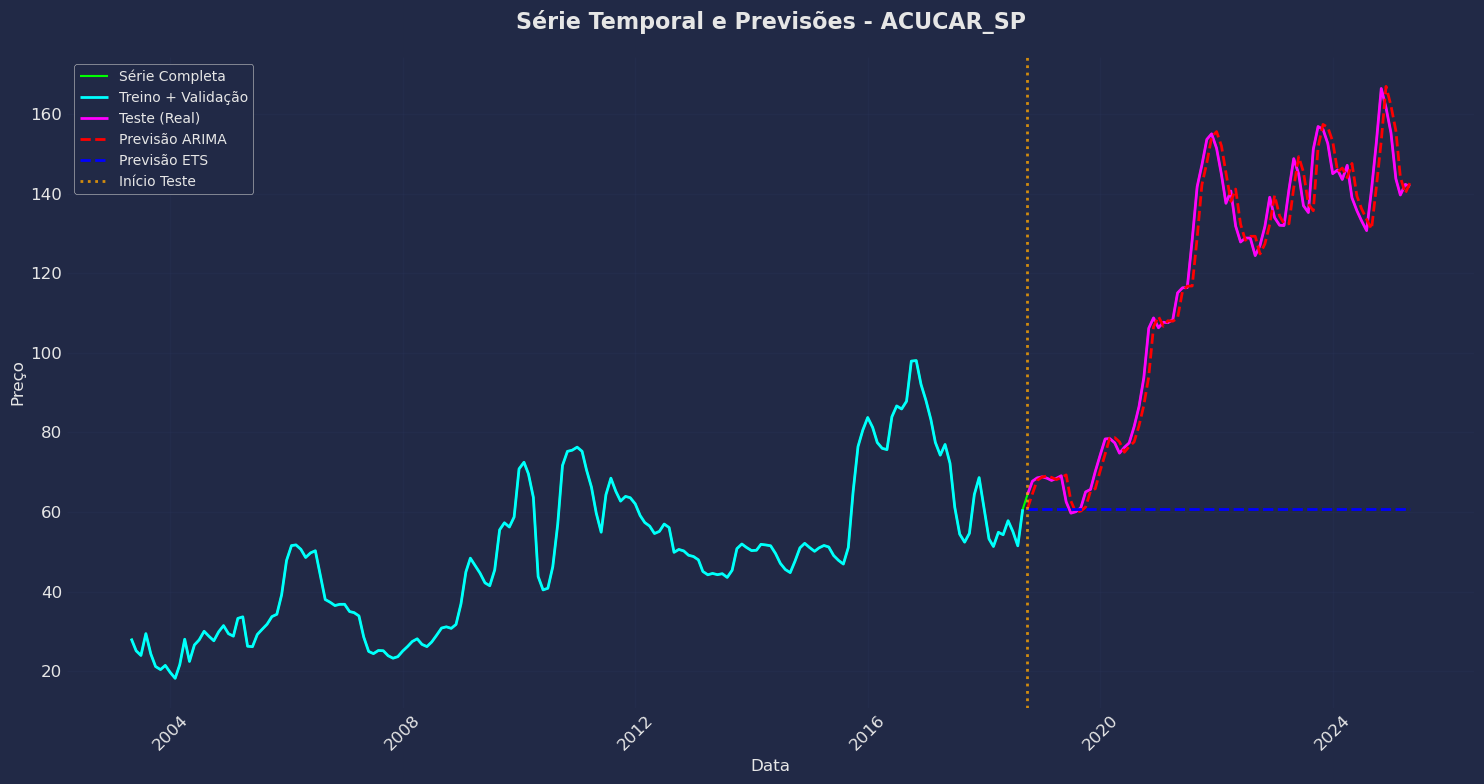

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


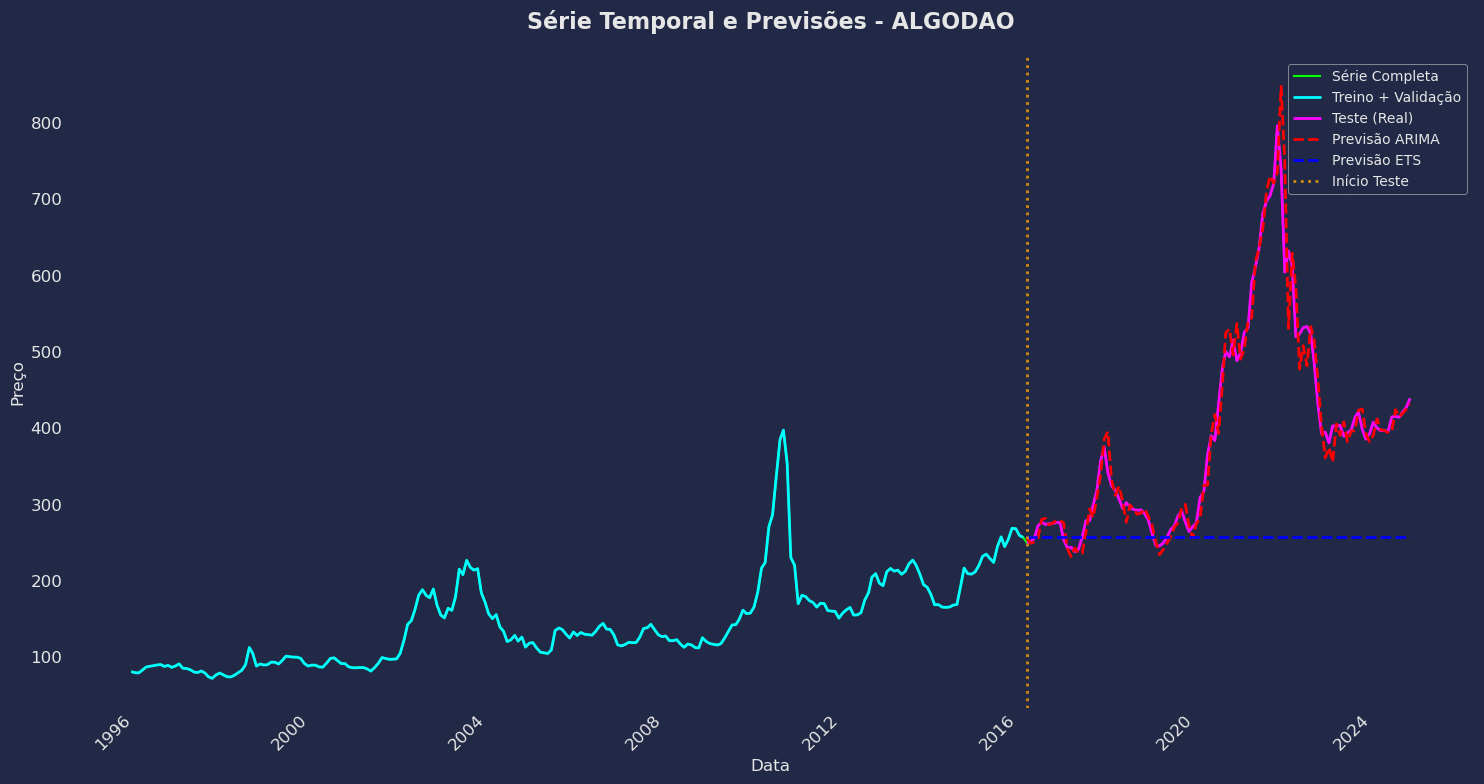

Gráfico exibido para: ALGODAO
--------------------------------------------------


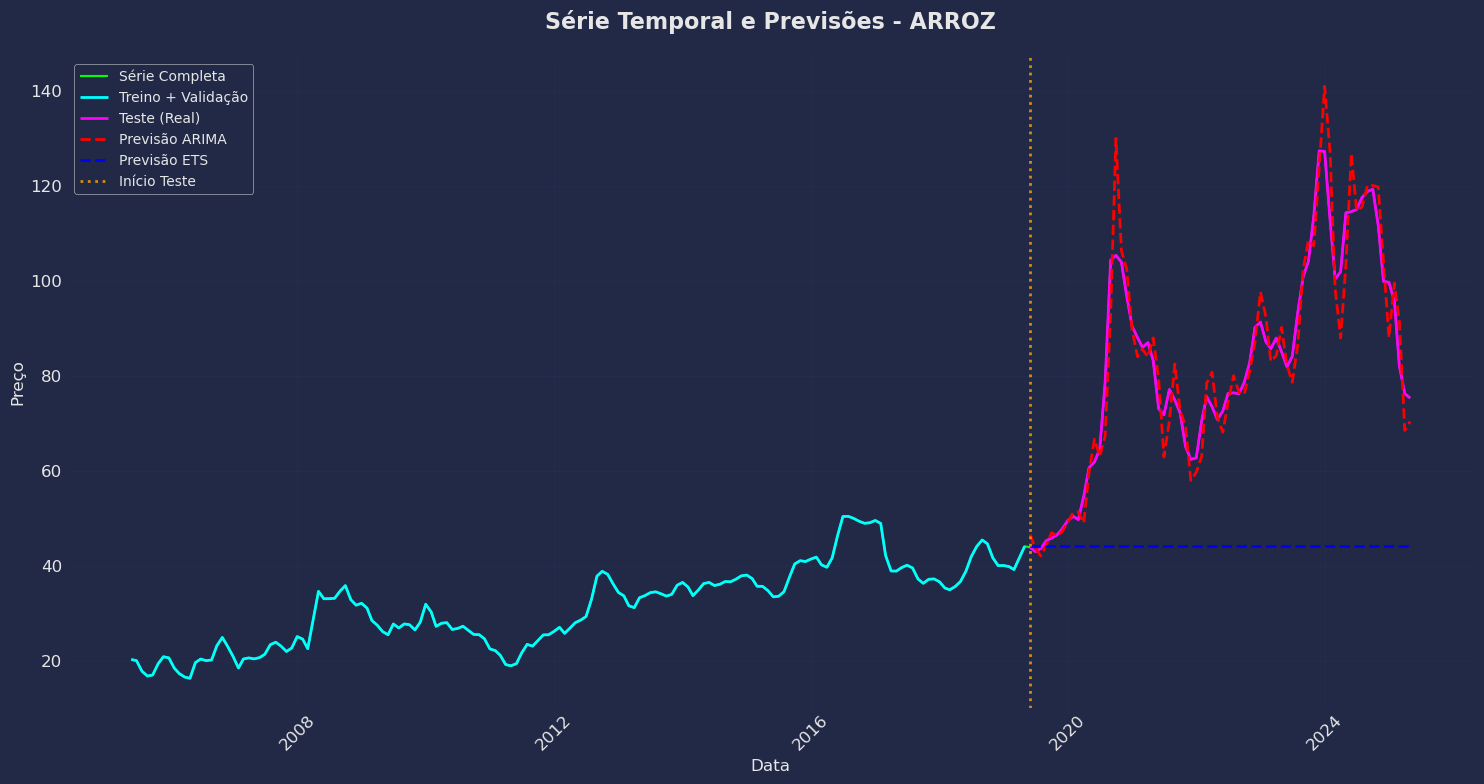

Gráfico exibido para: ARROZ
--------------------------------------------------


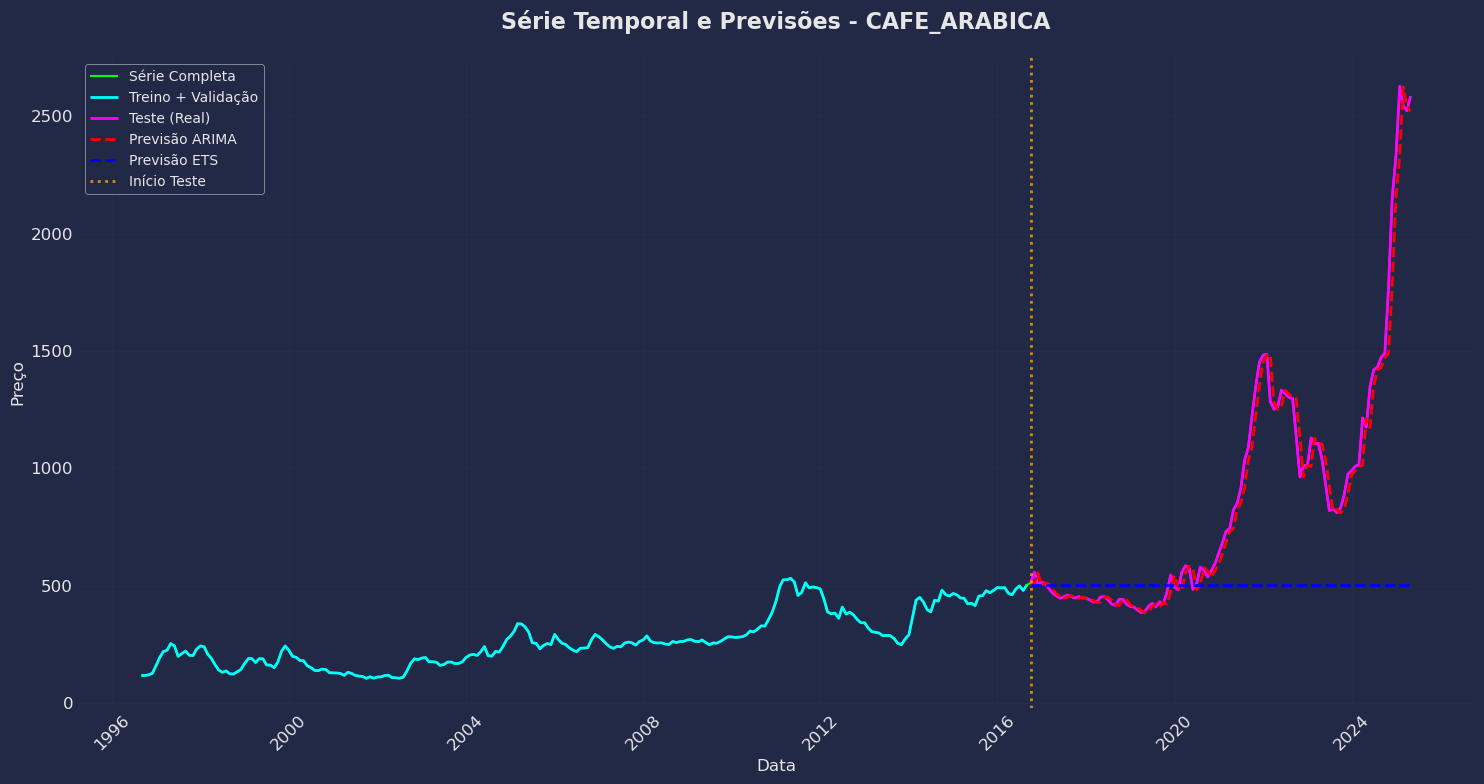

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


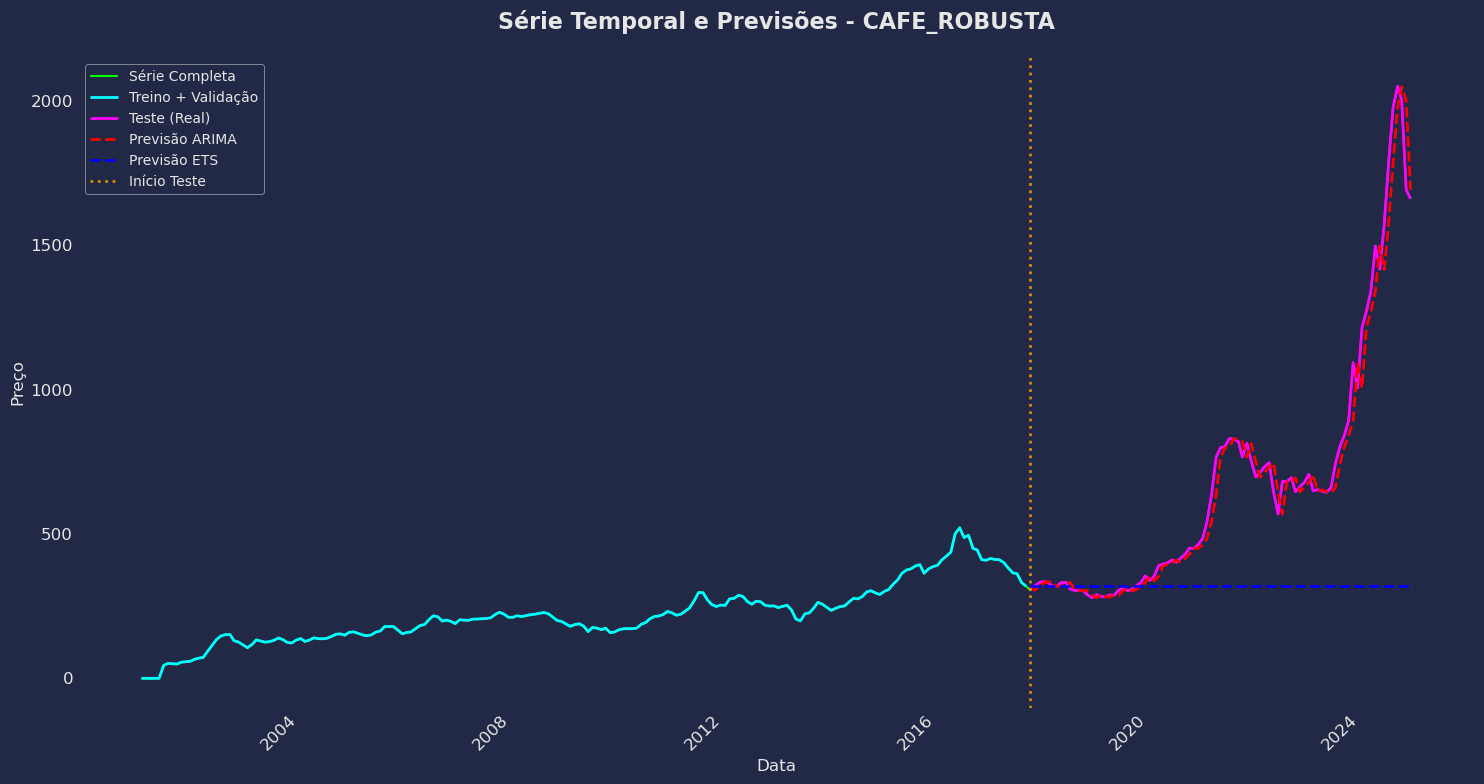

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


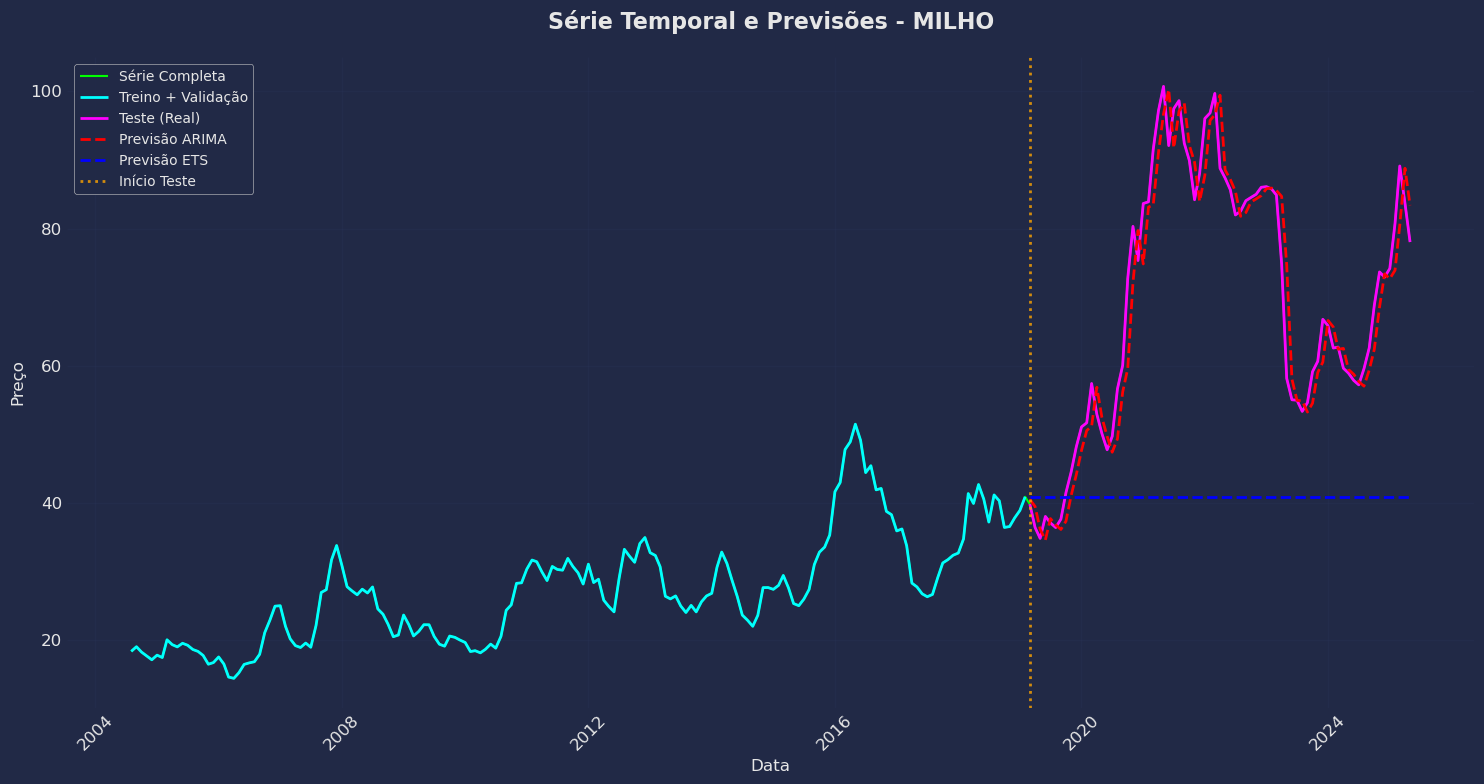

Gráfico exibido para: MILHO
--------------------------------------------------


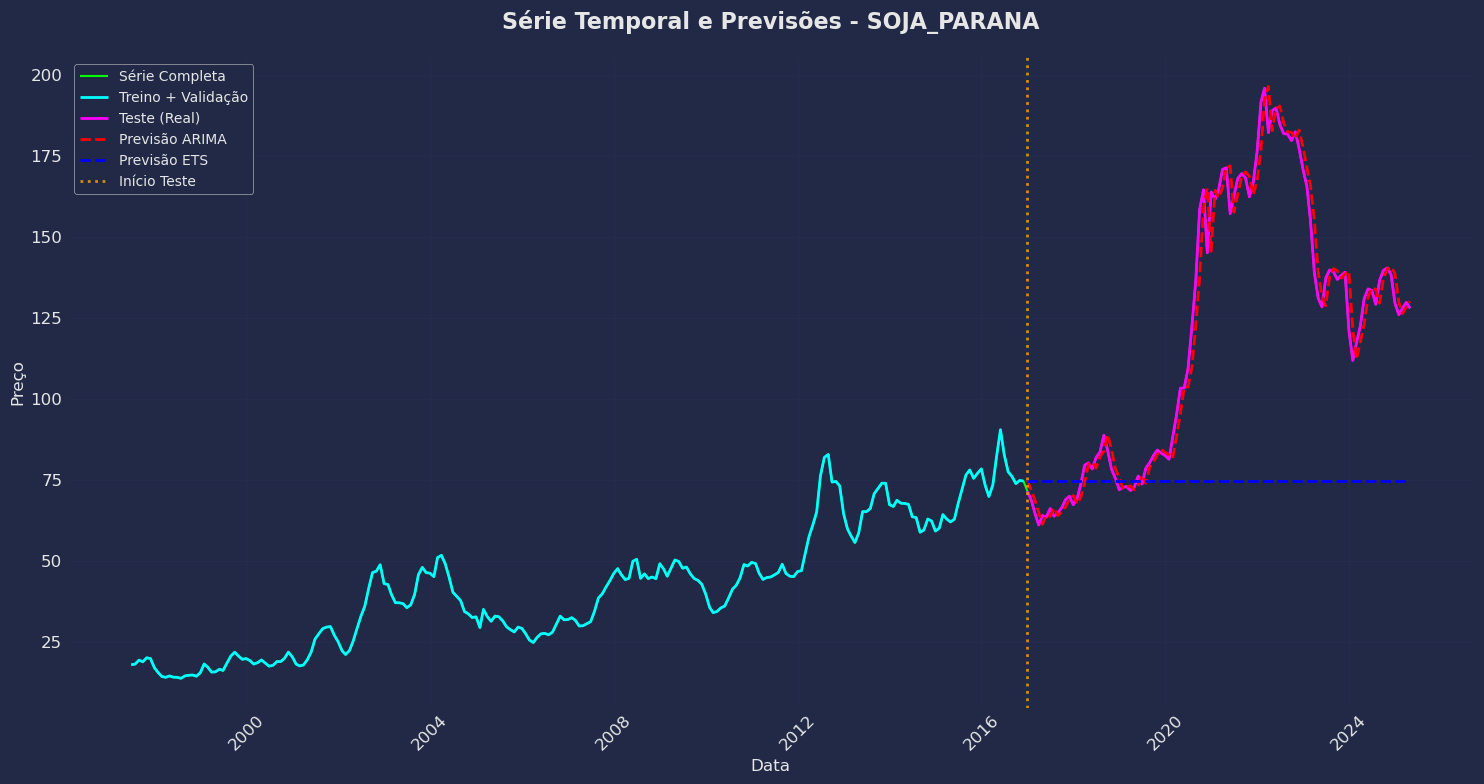

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


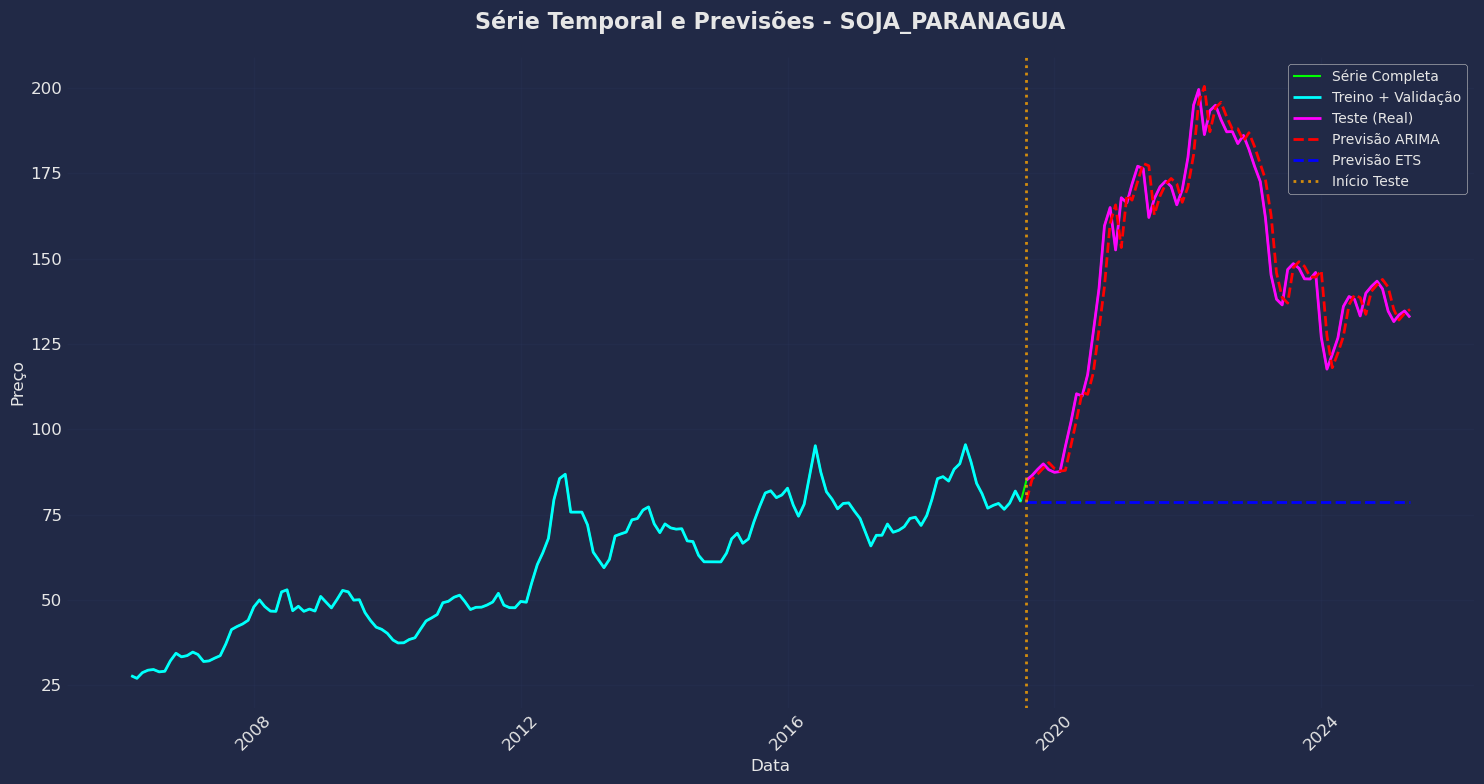

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


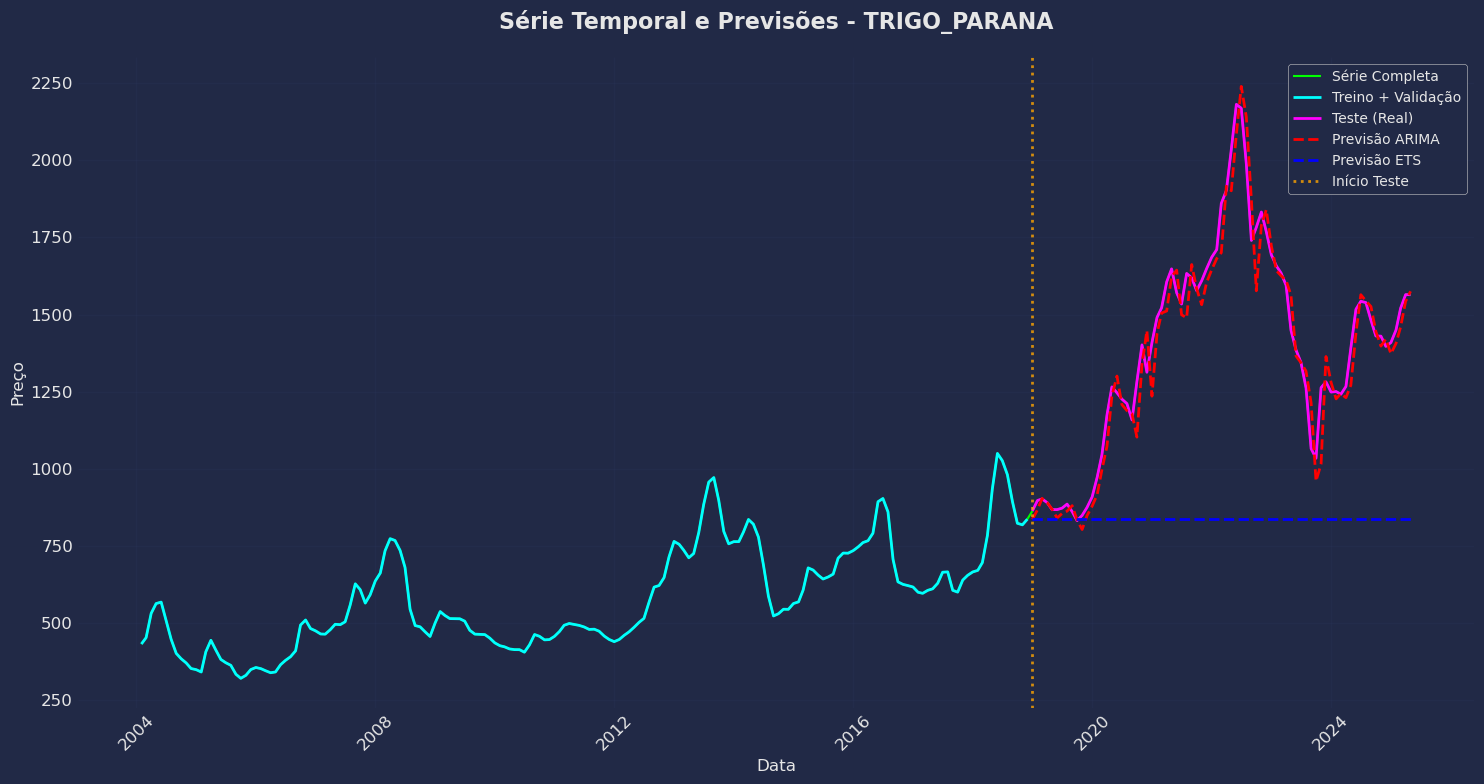

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


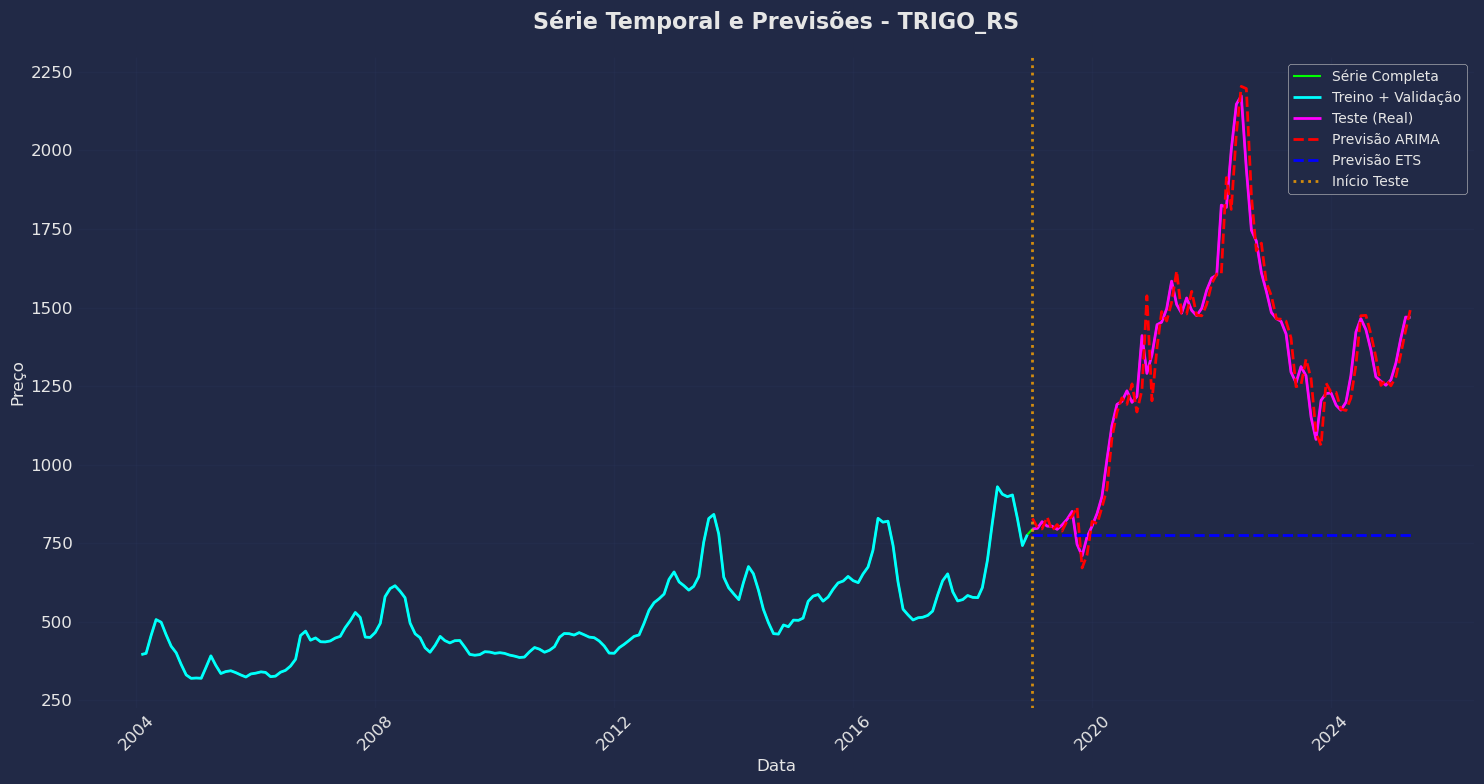

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [54]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    """
    Plota a série completa e as previsões para cada commodity individualmente
    """
    unique_ids = df_brl['unique_id'].unique()
    
    if forecasts_df['ds'].dtype.name.startswith("period"):
        forecasts_df = forecasts_df.copy()
        forecasts_df['ds'] = forecasts_df['ds'].dt.to_timestamp()

    if full_train['ds'].dtype.name.startswith("period"):
        full_train = full_train.copy()
        full_train['ds'] = full_train['ds'].dt.to_timestamp()

    if test['ds'].dtype.name.startswith("period"):
        test = test.copy()
        test['ds'] = test['ds'].dt.to_timestamp()

    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lime', linewidth=1.5, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='cyan', linewidth=2, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='fuchsia', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['yhat_arima'], 
                color='red', linewidth=2, linestyle='--', label='Previsão ARIMA')
        
        ax.plot(forecast_data['ds'], forecast_data['yhat_ets'], 
                color='blue', linewidth=2, linestyle='--', label='Previsão ETS')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                       linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                     fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, final_preds)